In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo22010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo41010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo43010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo43020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21050_sx1.fits'],
      dtype='<U67')

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21040_x1d.fits
G140M
[553.90546]


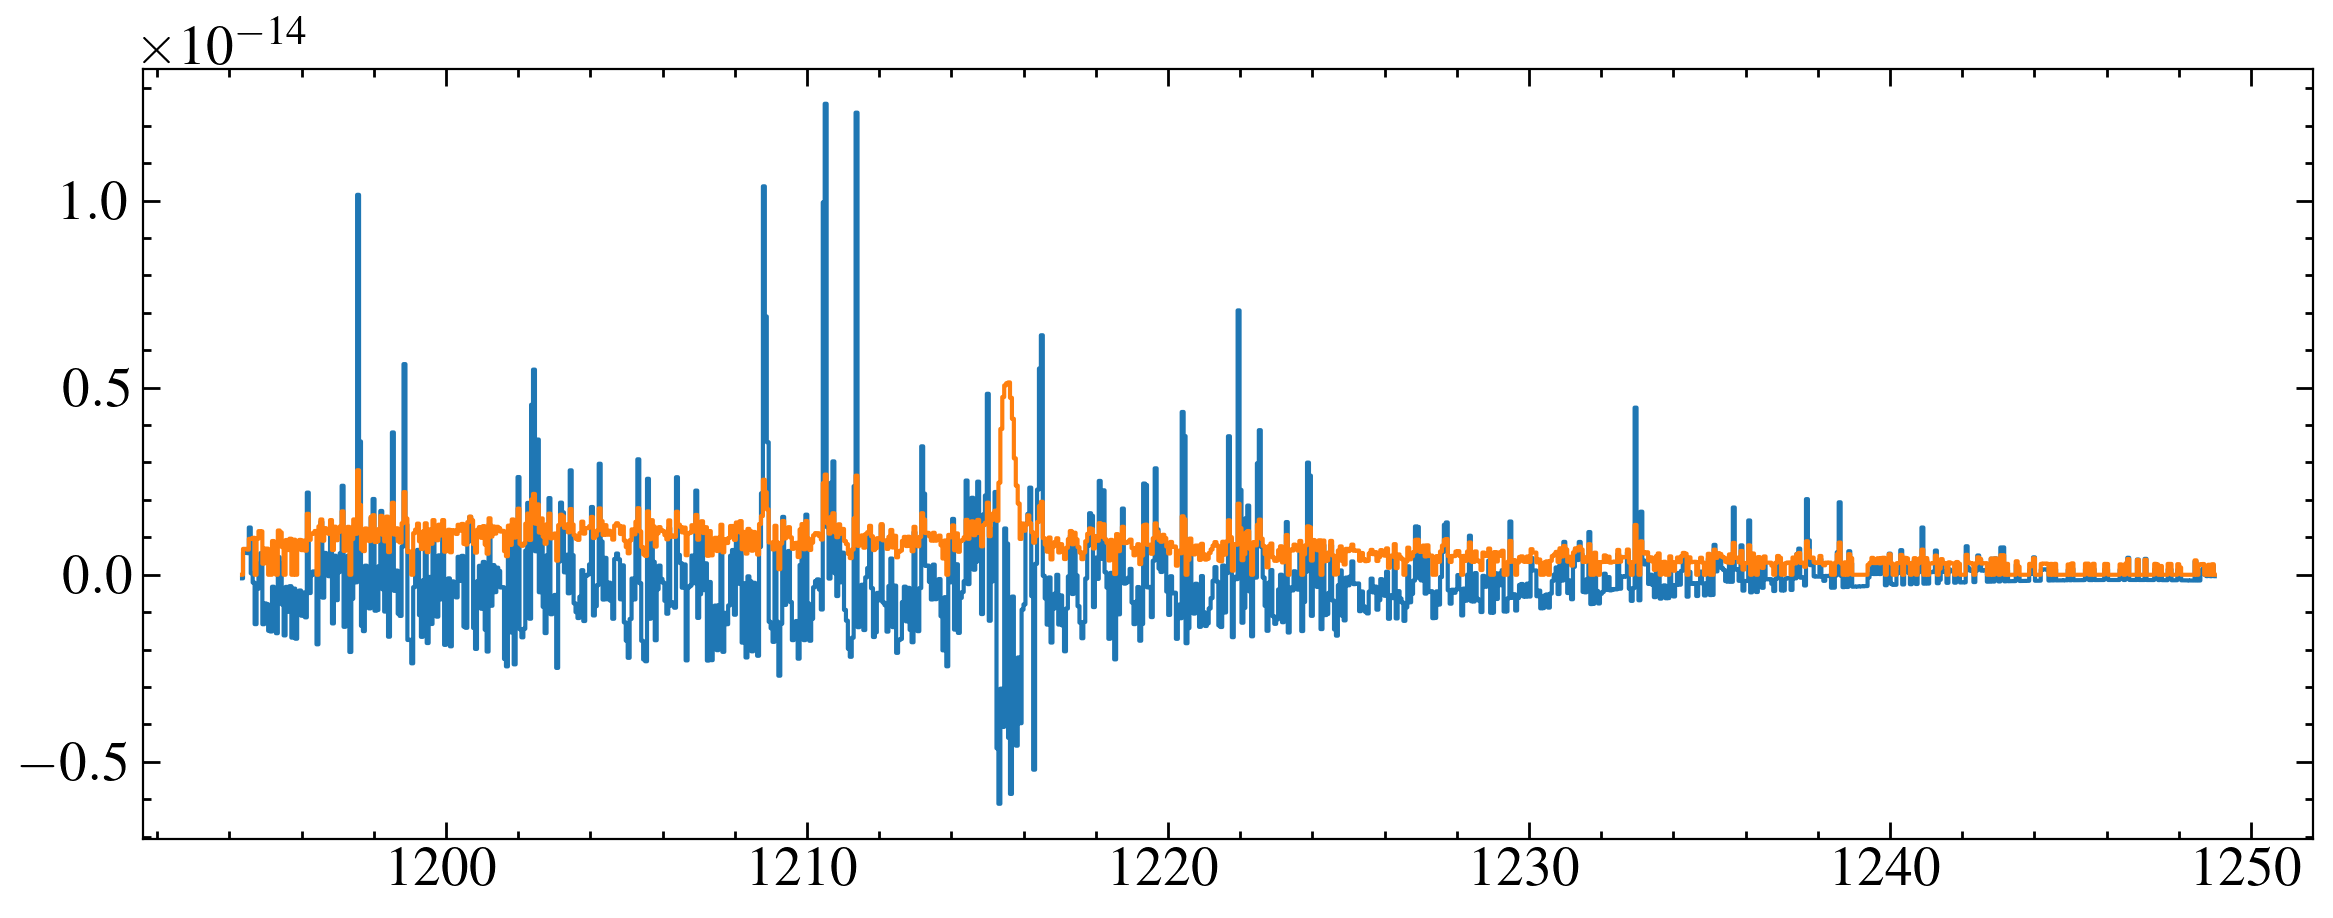

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo22010_x1d.fits
G140L
[719.6955]


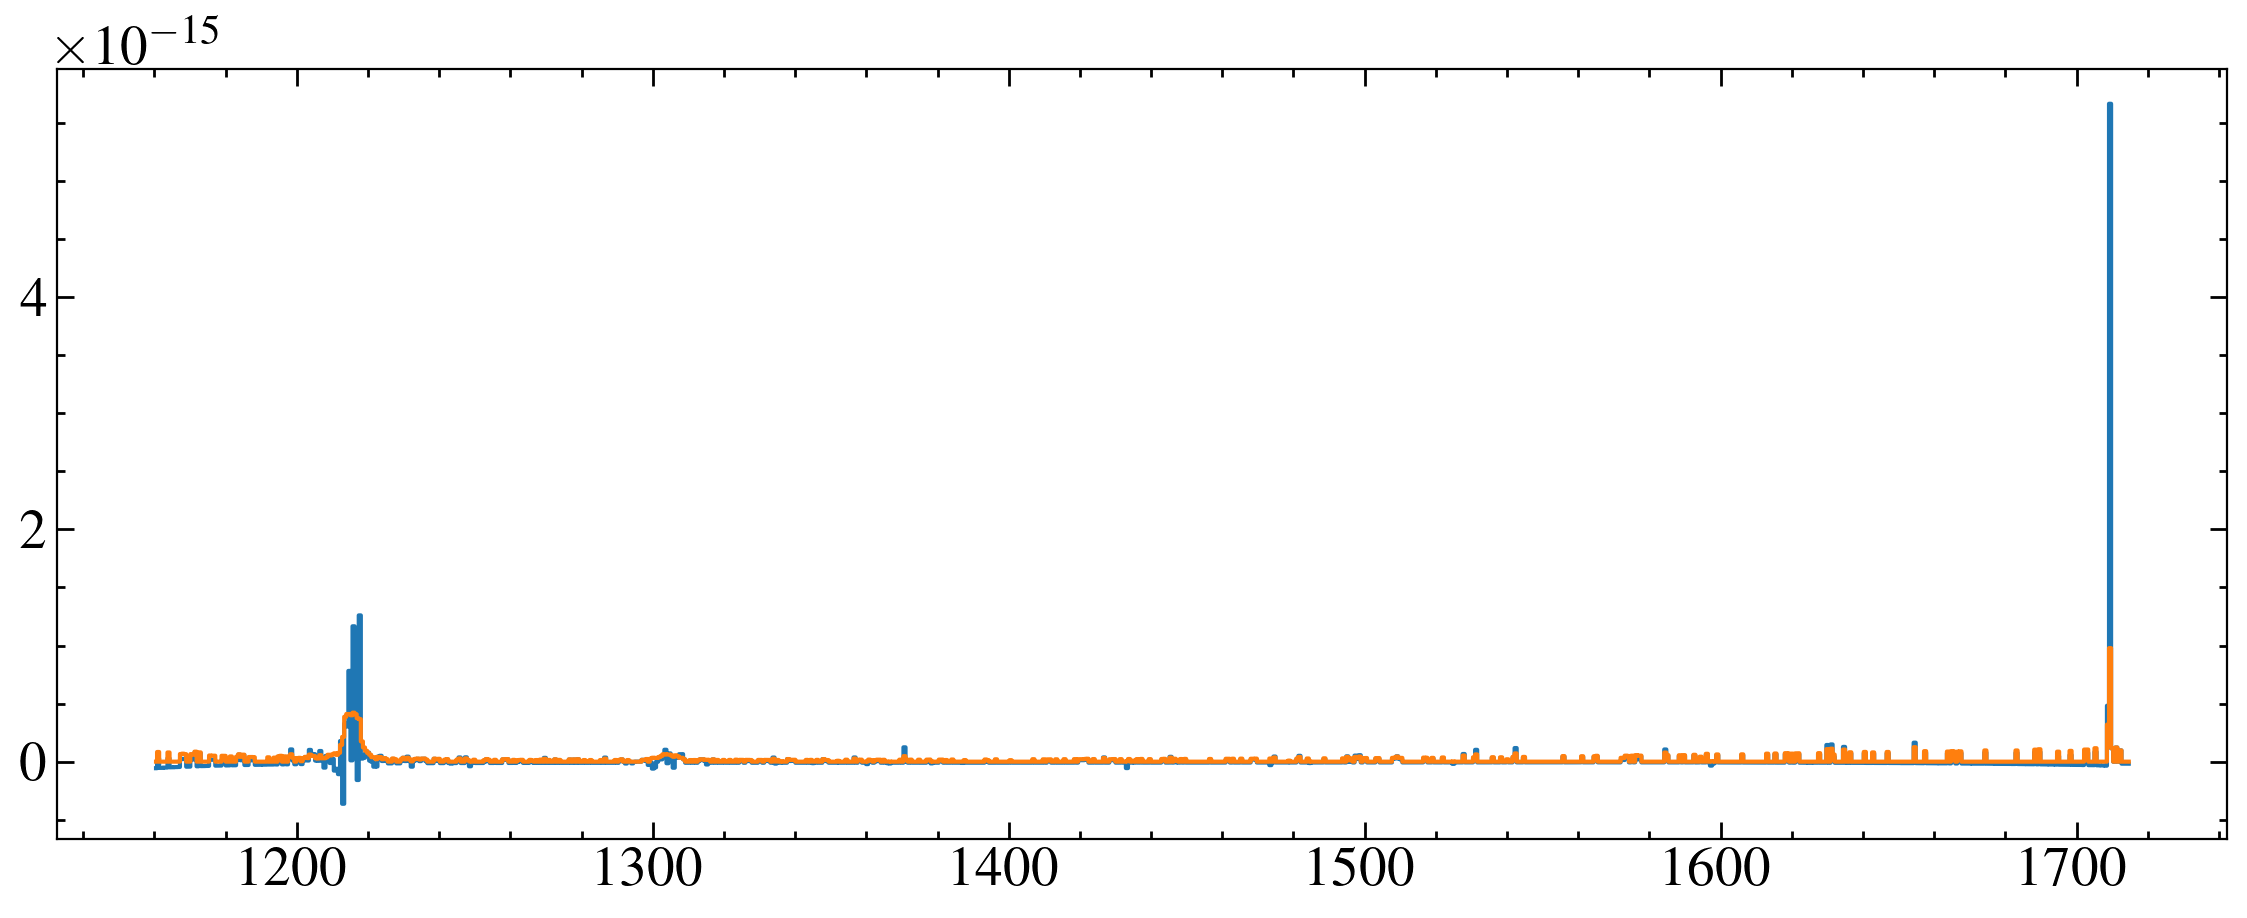

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo41010_x1d.fits
G140M
[115.32747]


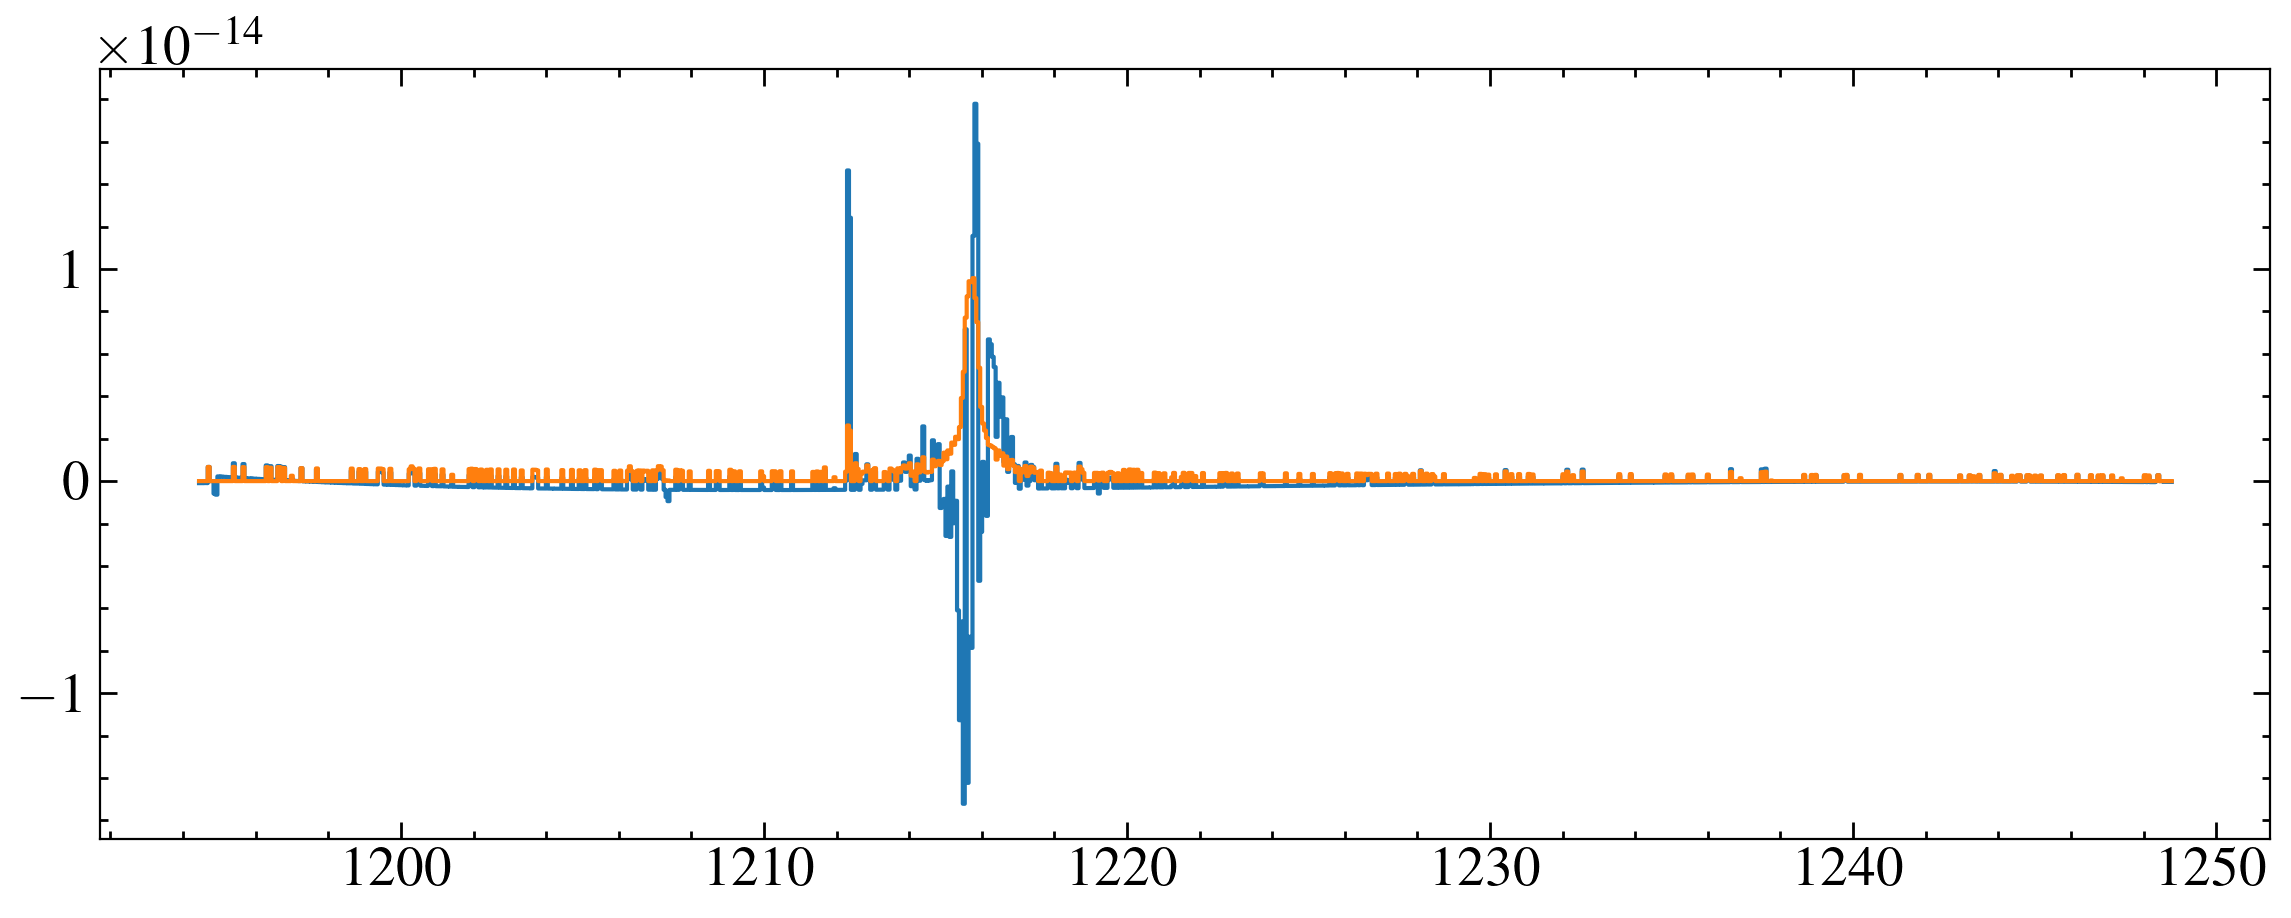

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo43010_x1d.fits
G140L
[510.53983]


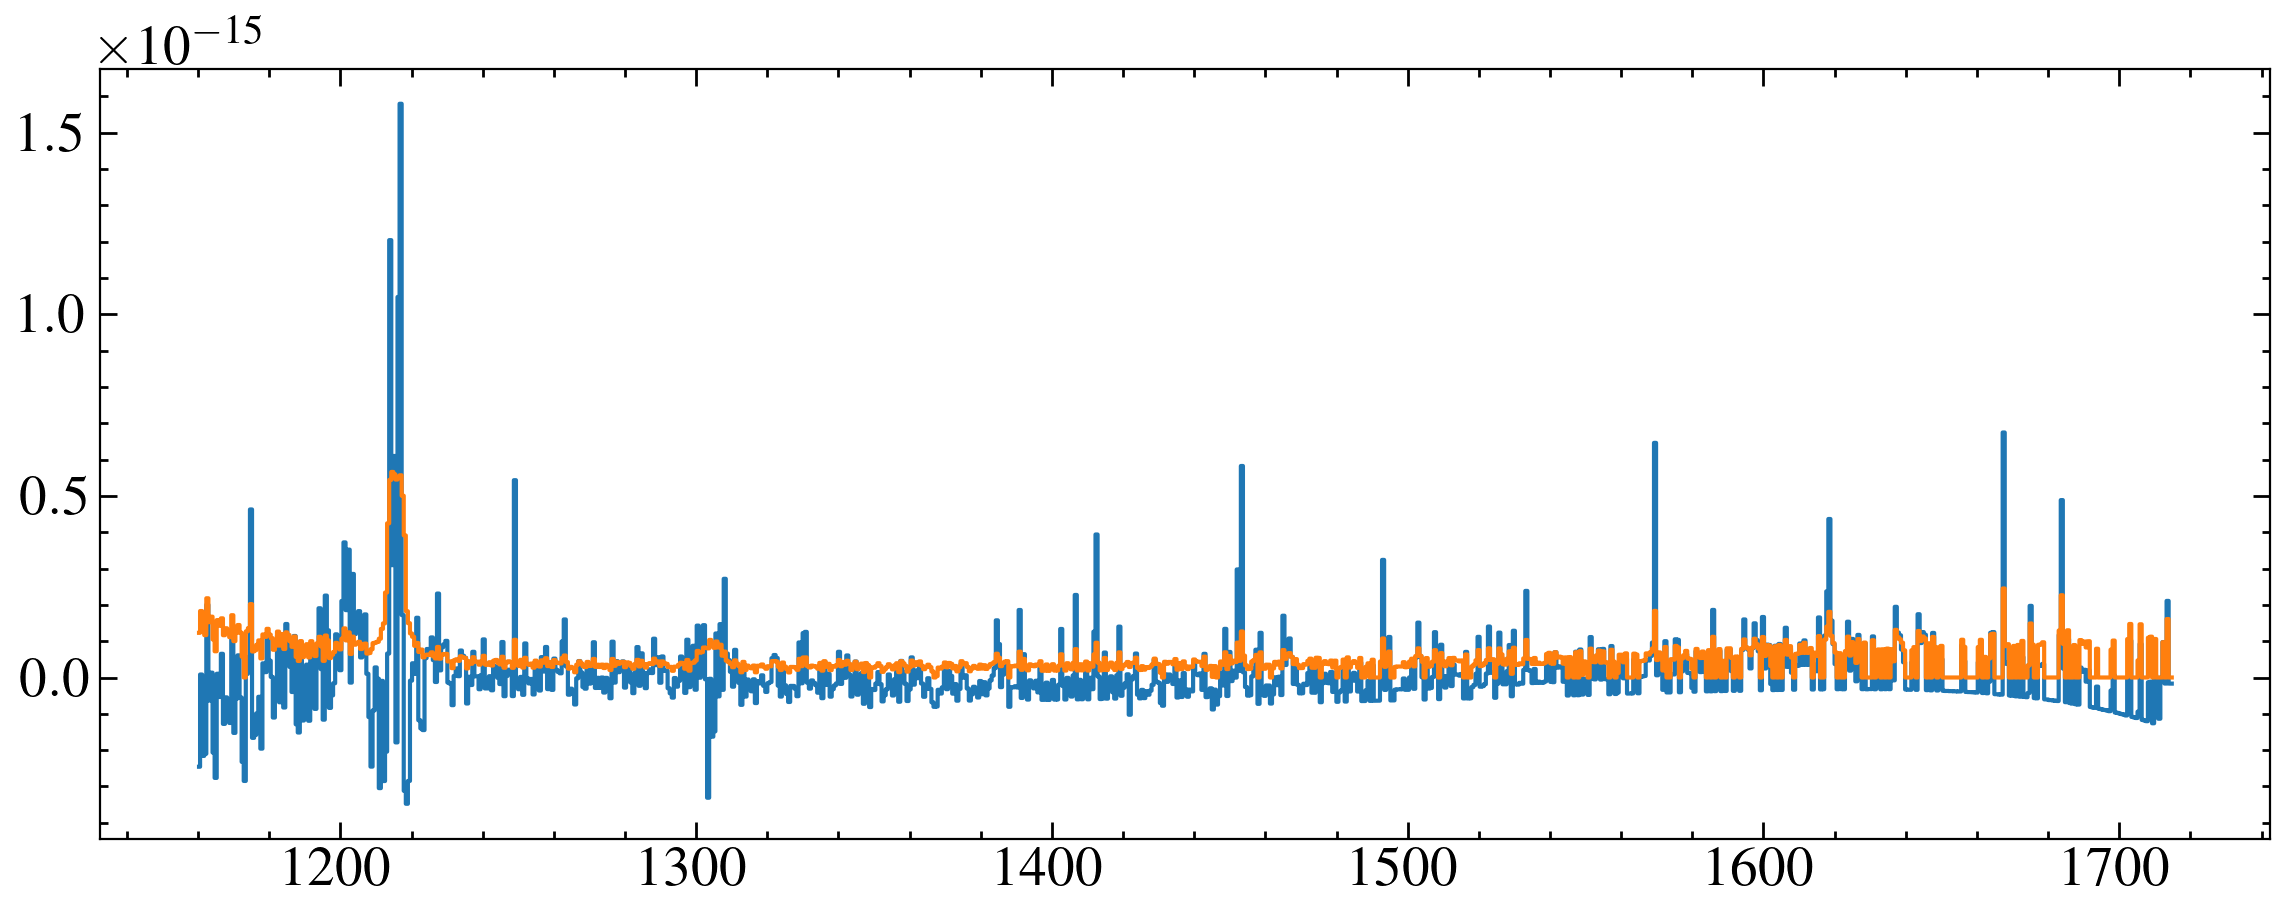

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo43020_x1d.fits
G230L
[535.2425]


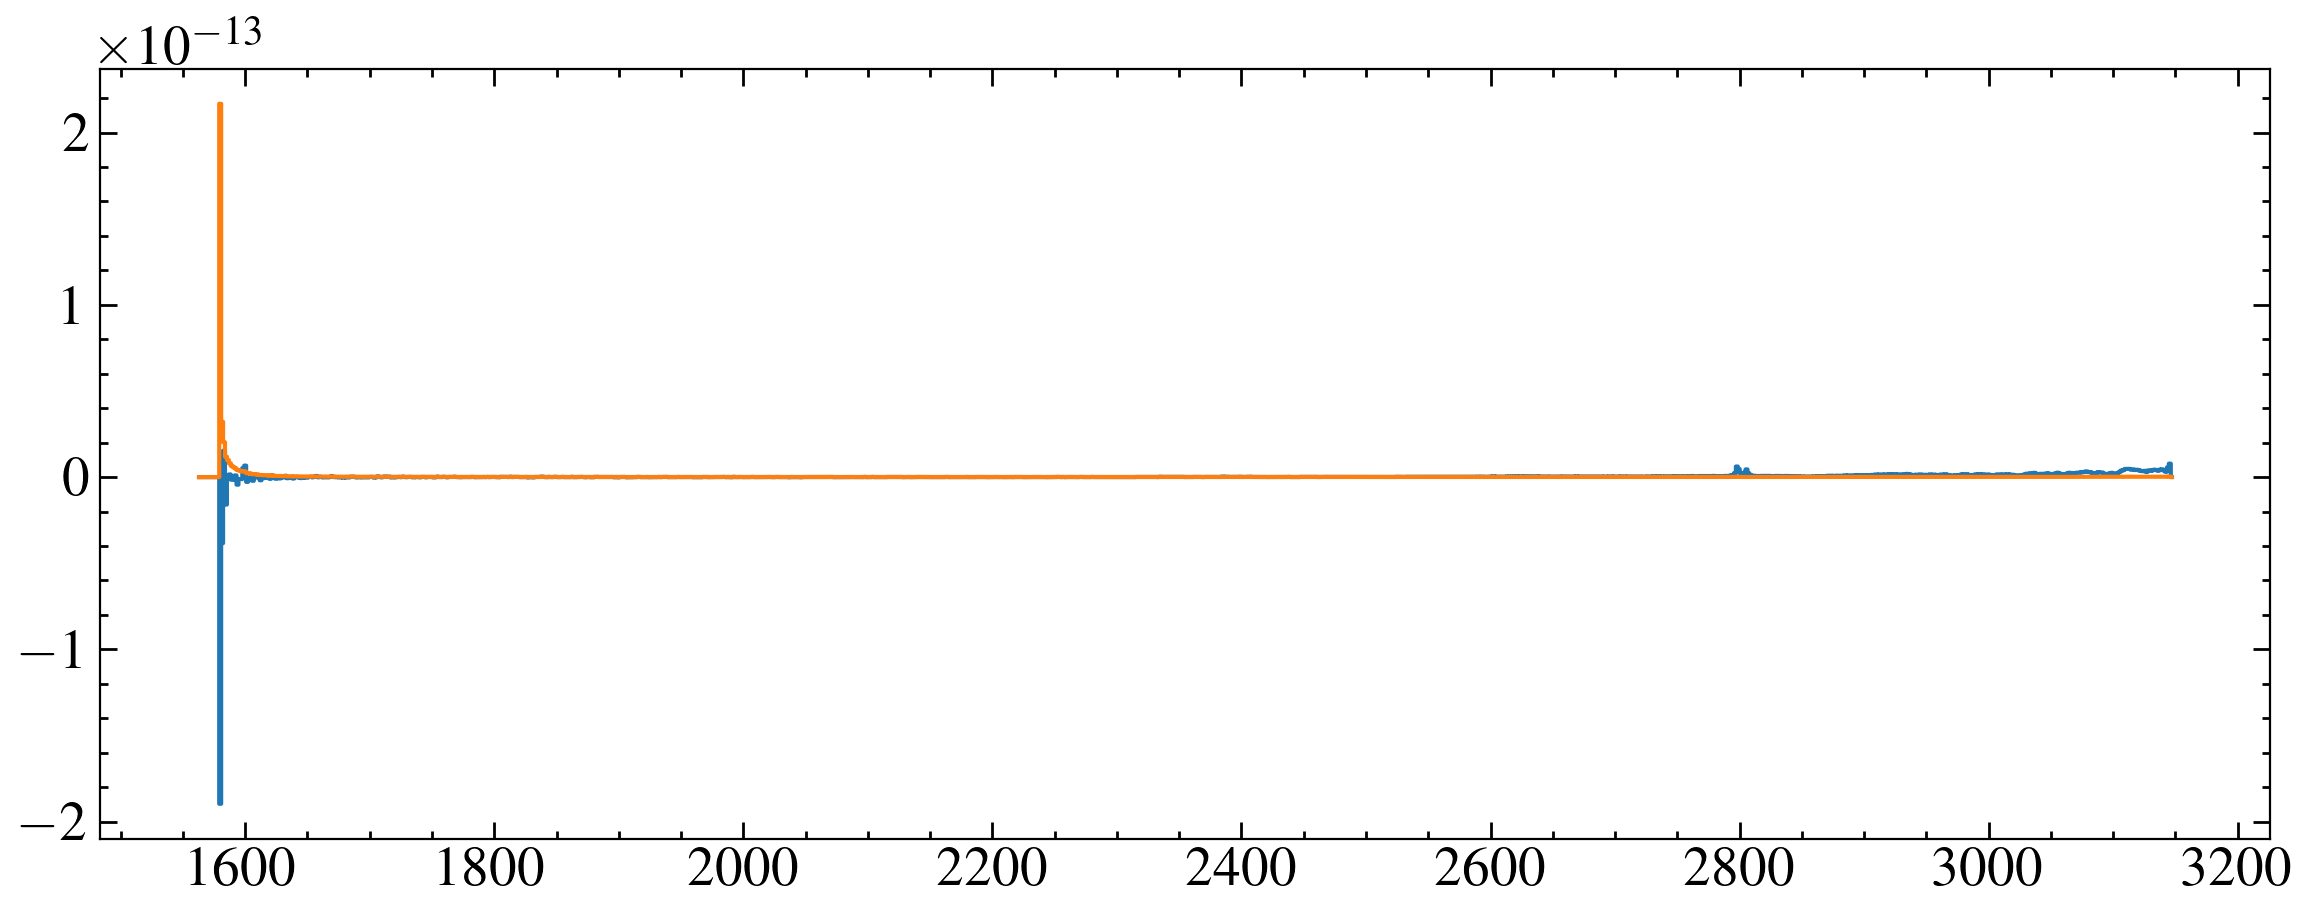

/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/oeoo21050_sx1.fits
G430L
[893.6261]


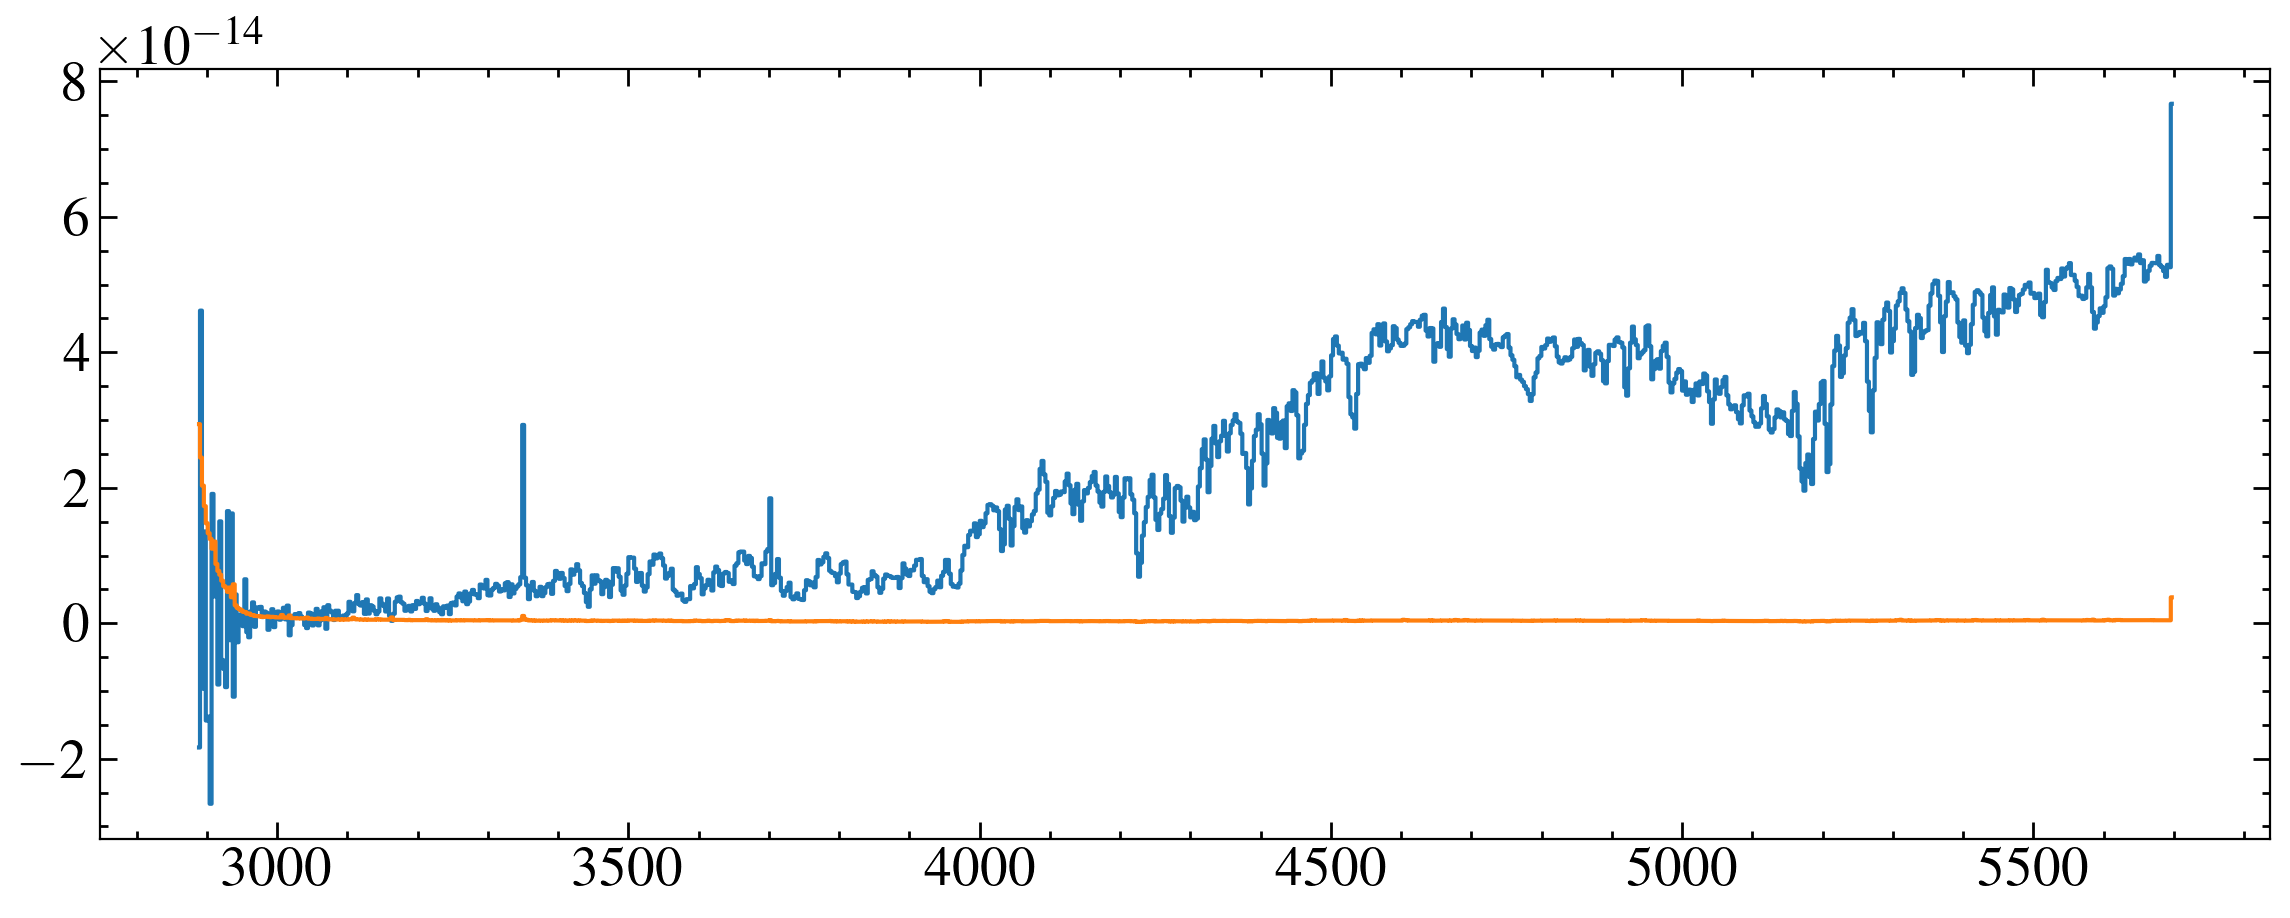

In [3]:
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    mask = w > 1160
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid', c='C0')
    plt.step(w, e, where='mid', c='C1')
    plt.show()

    

Bad extraction on oeoo21040.

In [4]:
import stistools
os.environ['oref'] = path

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [5]:
def build_trace_grid(SPTRCTAB, grating, cenwave):
    """
    Extends a grid of trace displacements to cover all y positions
    """
    data = fits.getdata(SPTRCTAB, 1)
    tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]
    all_y = np.arange(len(tracedata[0]['A2DISPL']))
    grid = interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')(all_y)
    tracegrid = [a+b for a, b in zip(grid, all_y)] 
    return tracegrid
    
def get_a2center(x, y, tracegrid):
    """
    get the trace a2center at a1center
    """
    xcol = np.array(tracegrid)[:,int(x)]
    xind = (np.abs(xcol - y)).argmin()
    a2center = xind + 1 #calstis is 1-indexed 
    return a2center

In [6]:
# xs = [410, 408]
# ys = [181, 151]
# for i, root in  enumerate(['oeoo21040','oeoo41010']):
#     flt = '{}/{}_flt.fits'.format(path, root)
#     SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
#     grating = fits.getheader(flt,0)['OPT_ELEM']
#     cenwave = fits.getheader(flt,0)['CENWAVE']
#     tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
#     rootname = fits.getheader(flt)['ROOTNAME'] 
#     outname = 'reextractions/toi-178/{}_new_x1d.fits'.format(rootname)
#     a2center = get_a2center(xs[i], ys[i], tracegrid)
#     print(a2center)
#     stistools.x1d.x1d(flt, output = outname, trailer='reextractions/toi-178/{}_new.trl'.format(rootname), a2center=ys[i], maxsrch=5)

In [7]:
# for i, root in  enumerate(['oeoo21040','oeoo41010']):

#     # root = 'oeoo21040'
    
#     fig, axes = plt.subplots(figsize = (12, 9), nrows=2, ncols=1, sharex=True)
#     xs = [1197, 1247]
#     data = fits.getdata('reextractions/toi-178/{}_new_x1d.fits'.format(root), 1)[0]
#     print(data['A2Center'])
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    
#     fi = convolve(f,  Box1DKernel(2))
#     ei = convolve(e,  Box1DKernel(2))/2**0.5
    
#     axes[0].step(w, fi*1e14, where='mid', label = 'Flux')
#     axes[0].step(w, ei*1e14, where='mid', alpha=0.5, label='Error')
#     axes[0].legend(frameon=True)
#     axes[0].set_ylabel('Flux (10$^{-14}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
#     axes[0].set_xlim(1197, 1247)
#     axes[0].set_ylim(-0.1, 1.9)
#     axes[0].set_title(root)
    
    
#     axes[1].step(w, fi/ei, where='mid')
#     # axes[1].step(w, f/e, where='mid')
#     axes[1].set_ylim(-1, 8.5)
#     axes[1].set_xlabel('Wavelength (\AA)')
#     axes[1].set_ylabel('S/N')
    
#     plt.tight_layout()
#     # plt.savefig('plots/toi-178_{}_sn.png'.format(root), facecolor='w')
#     # plt.savefig('plots/toi-178_{}_sn.pdf'.format(root))
#     plt.show()


And again for visit 22. 

In [8]:
# for root in  ['oeoo22010']:
#     flt = '{}/{}_flt.fits'.format(path, root)
#     SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
#     grating = fits.getheader(flt,0)['OPT_ELEM']
#     cenwave = fits.getheader(flt,0)['CENWAVE']
#     tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
#     rootname = fits.getheader(flt)['ROOTNAME'] 
#     outname = 'reextractions/toi-178/{}_new_x1d.fits'.format(rootname)
#     a2center = get_a2center(372, 109, tracegrid)
#     print(a2center)
#     stistools.x1d.x1d(flt, output = outname, trailer='reextractions/toi-178/{}_new.trl'.format(rootname), a2center=a2center, maxsrch=5)

In [9]:
# root = 'oeoo22010'

# fig, axes = plt.subplots(figsize = (12, 9), nrows=2, ncols=1, sharex=True)
# xs = [1197, 1247]
# data = fits.getdata('reextractions/toi-178/{}_new_x1d.fits'.format(root), 1)[0]
# print(data['A2Center'])
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# mask = w > 1160
# w, f, e = w[mask], f[mask], e[mask]


# fi = convolve(f,  Box1DKernel(2))
# ei = convolve(e,  Box1DKernel(2))/2**0.5

# axes[0].step(w, fi*1e14, where='mid', label = 'Flux')
# axes[0].step(w, ei*1e14, where='mid', alpha=0.5, label='Error')
# axes[0].legend(frameon=True)
# axes[0].set_ylabel('Flux (10$^{-14}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# # axes[0].set_xlim(1197, 1247)
# # axes[0].set_ylim(-0.1, 1.9)
# axes[0].set_title(root)


# axes[1].step(w, fi/ei, where='mid')
# # axes[1].step(w, f/e, where='mid')
# axes[1].set_ylim(-1, 8.5)
# axes[1].set_xlabel('Wavelength (\AA)')
# axes[1].set_ylabel('S/N')

# plt.tight_layout()
# # plt.savefig('plots/toi-178_{}_sn.png'.format(root), facecolor='w')
# # plt.savefig('plots/toi-178_{}_sn.pdf'.format(root))
# # plt.show()


In [10]:
# root = 'oeoo22010'

# fig, axes = plt.subplots(figsize = (12, 5), nrows=1, ncols=1, sharex=True)
# xs = [1197, 1247]
# data = fits.getdata('reextractions/toi-178/{}_new_x1d.fits'.format(root), 1)[0]
# print(data['A2Center'])
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
# w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

# mask = w > 1160
# w, f, e = w[mask], f[mask], e[mask]


# fi = convolve(f,  Box1DKernel(2))
# ei = convolve(e,  Box1DKernel(2))/2**0.5
# # fi = f
# # ei = e

# axes.step(w, fi*1e15, where='mid', label = 'Flux')
# axes.step(w, ei*1e15, where='mid', alpha=0.5, label='Error')
# axes.legend(frameon=True)
# axes.set_ylabel('Flux (10$^{-15}$\,erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
# # axes[0].set_xlim(1197, 1247)
# # axes.set_ylim(-0.1, 0.3)
# axes.set_title(root)


# # axes[1].step(w, fi/ei, where='mid')
# # axes[1].step(w, f/e, where='mid')
# # axes[1].set_ylim(-1, 8.5)
# axes.set_xlabel('Wavelength (\AA)')
# # axes[1].set_ylabel('S/N')

# plt.tight_layout()
# plt.savefig('plots/toi-178_{}.png'.format(root), facecolor='w')
# plt.savefig('plots/toi-178_{}.pdf'.format(root))
# # plt.show()


the two G140Ms are quite different 

In [11]:
# new_x1ds = glob.glob('reextractions/toi-178/*x1d.fits')
# new_x1ds

In [12]:
# fig, ax = plt.subplots()

# for x in [new_x1ds[0], new_x1ds[2]]:
#     print(x)
#     data = fits.getdata(x, 1)[0]
#     print(data['A2Center'])
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     # mask = w > 1160
#     # w, f, e = w[mask], f[mask], e[mask]
#     # plt.step(w, f, where='mid', c='C0')
#     # ax.step(w, f, where='mid', alpha =0.7)
#     # ax.step(w, data['GROSS'], where='mid', ls='--')
#     ax.step(w, data['BACKGROUND'], where='mid', ls='--')
#     ax.step(w, data['NET'], where='mid', ls='--')
#     # plt.step(w, e, where='mid', c='C1')
#     # plt.show()

# ax.set_xlim(1214, 1218)

In [13]:
data.names

['SPORDER',
 'NELEM',
 'WAVELENGTH',
 'GROSS',
 'BACKGROUND',
 'NET',
 'FLUX',
 'ERROR',
 'NET_ERROR',
 'DQ',
 'A2CENTER',
 'EXTRSIZE',
 'MAXSRCH',
 'BK1SIZE',
 'BK2SIZE',
 'BK1OFFST',
 'BK2OFFST',
 'EXTRLOCY',
 'OFFSET']

In [14]:
# data['NET']

202040807 Reextracting them all...

oeoo21040
[179.89566]
oeoo22010
[109.91156]
oeoo41010
[152.12978]
oeoo43010
[143.5168]
reextractions/toi-178/oeoo43010_new_x1d.fits
G140L
143.5168


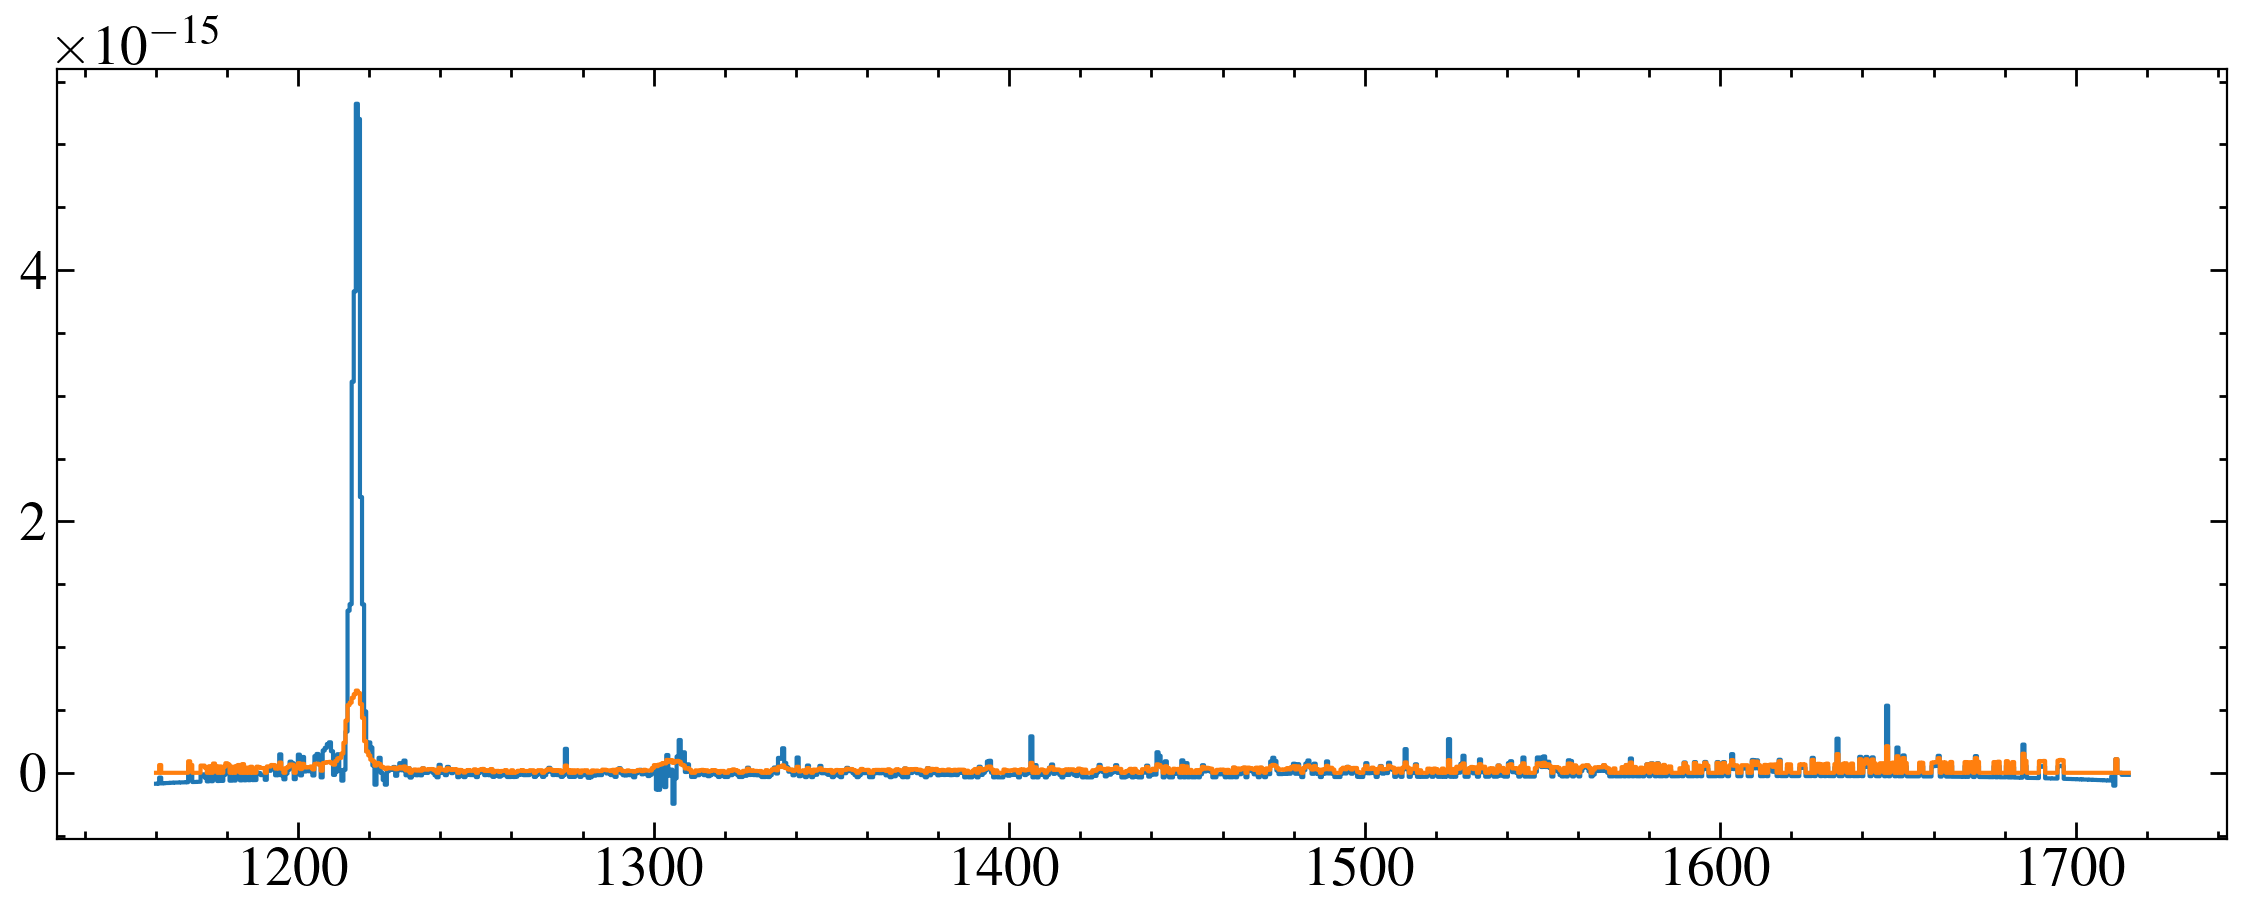

reextractions/toi-178/oeoo41010_new_x1d.fits
G140M
152.12978


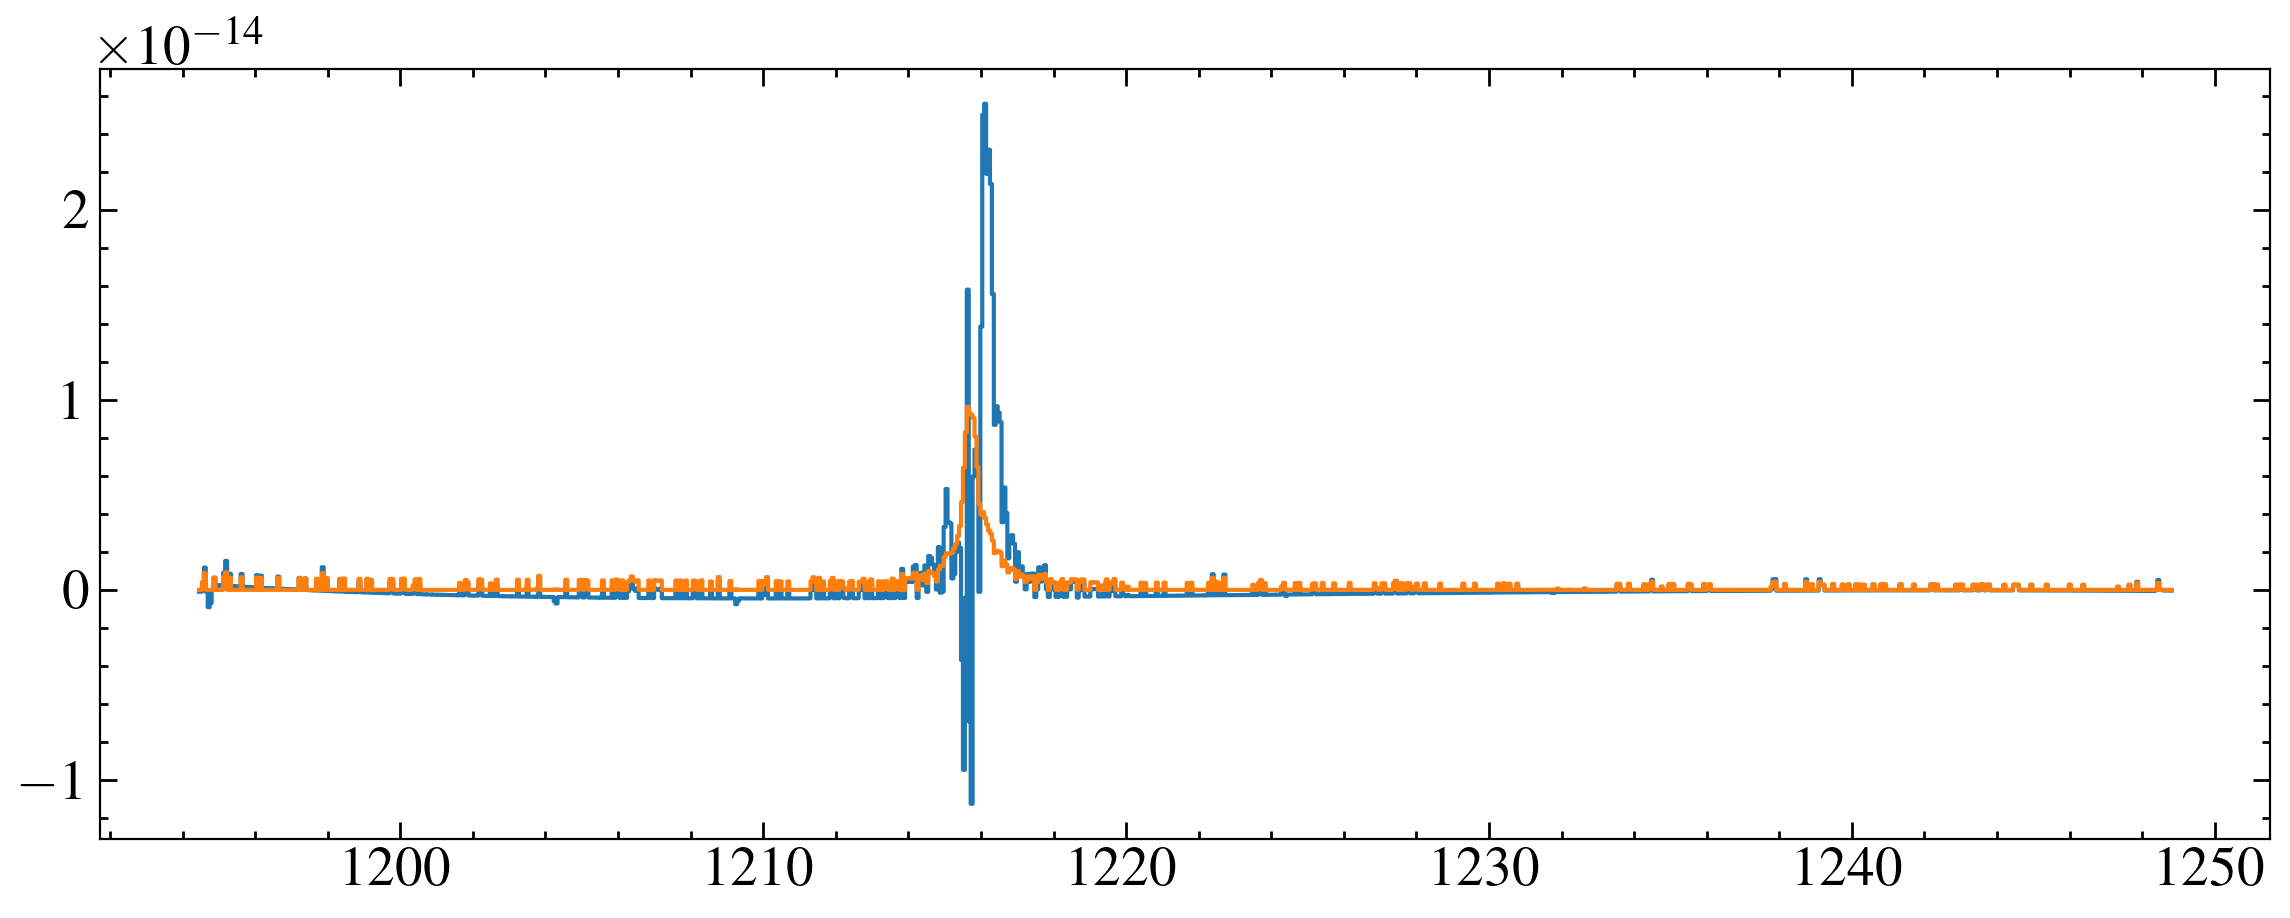

reextractions/toi-178/oeoo22010_new_x1d.fits
G140L
109.91156


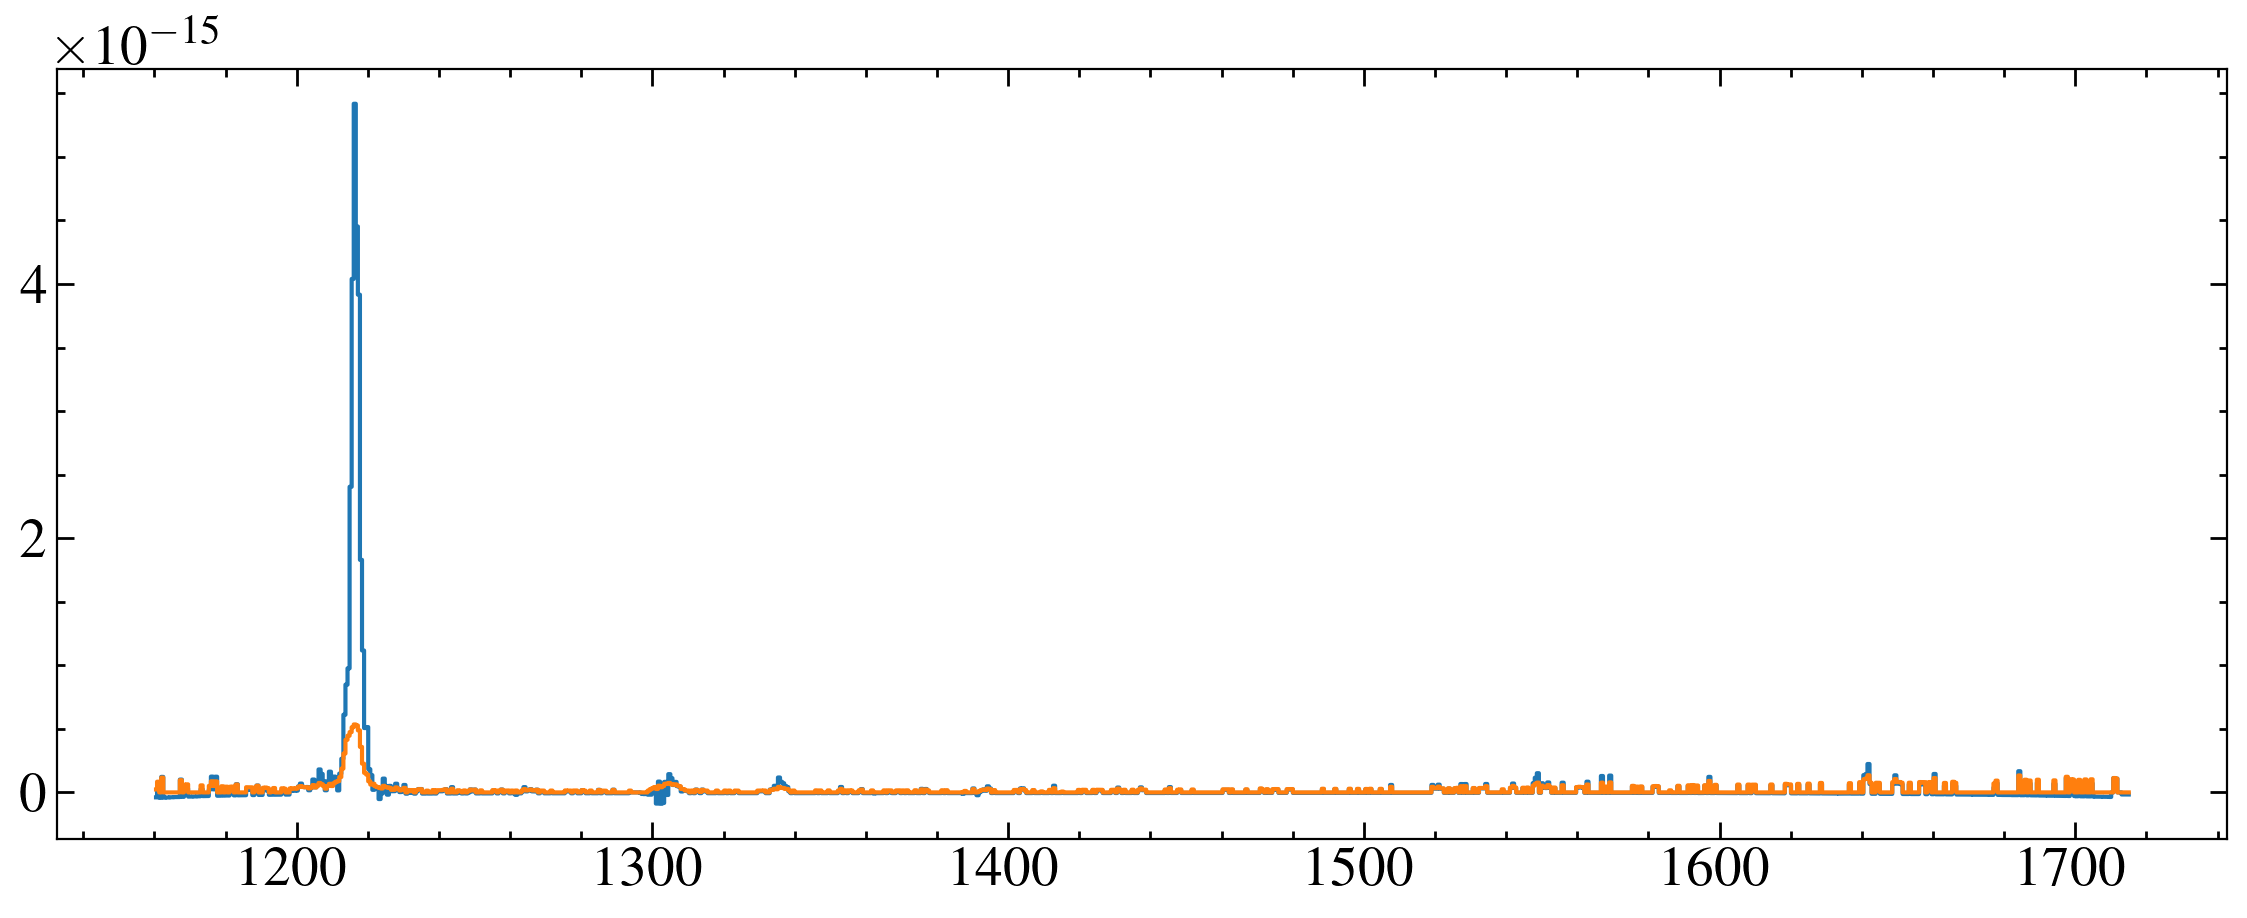

reextractions/toi-178/oeoo21040_new_x1d.fits
G140M
179.89566


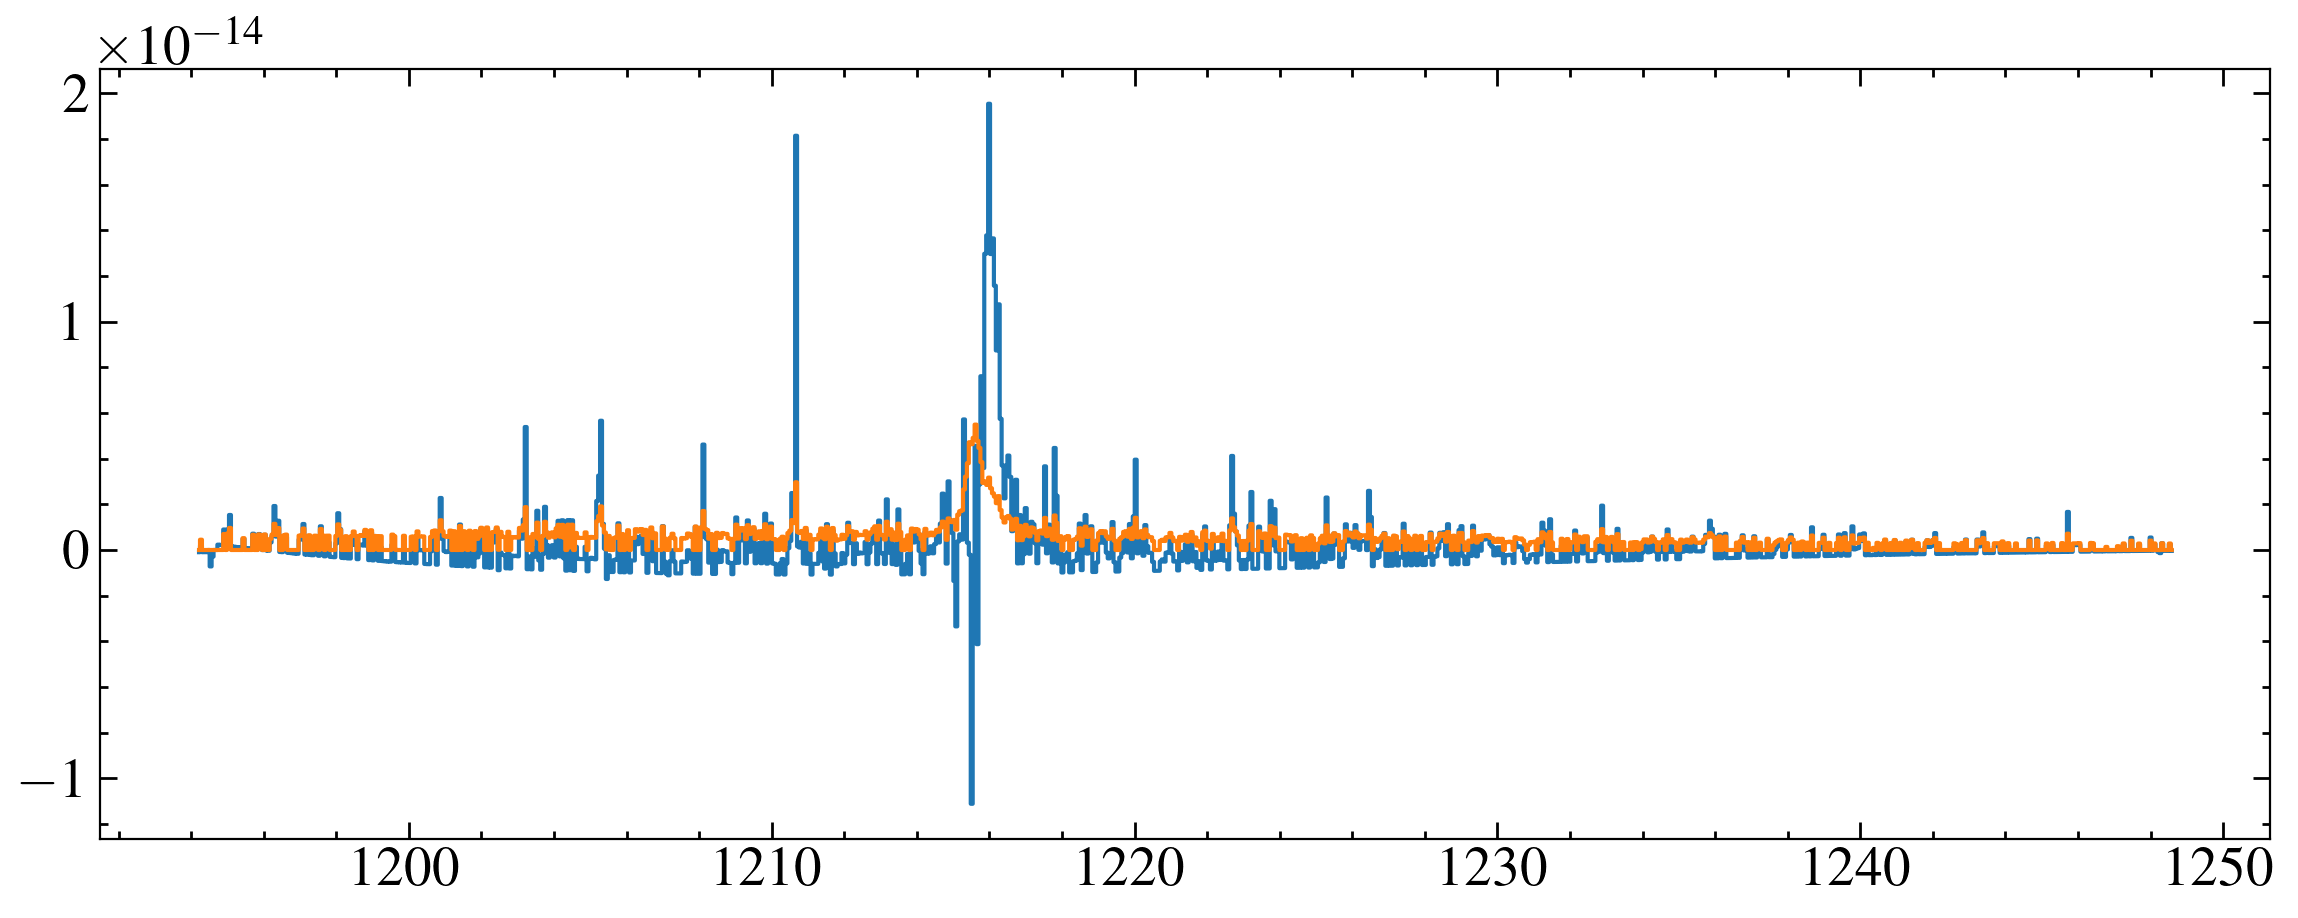

In [15]:
roots = ['oeoo21040', 'oeoo22010', 'oeoo41010', 'oeoo43010']

star = 'toi-178'
xs = [417, 373, 422, 371]
ys = [182, 110, 152, 142]

for i, root in  enumerate(roots):
    flt = '{}{}_flt.fits'.format(path, root)
    SPTRCTAB = fits.getheader(flt,0)['SPTRCTAB']
    grating = fits.getheader(flt,0)['OPT_ELEM']
    cenwave = fits.getheader(flt,0)['CENWAVE']
    tracegrid = build_trace_grid(path+SPTRCTAB[5:], grating, cenwave)
    rootname = fits.getheader(flt)['ROOTNAME'] 
    outname = 'reextractions/{}/{}_new_x1d.fits'.format(star, rootname)
    if os.path.exists(outname):
        os.remove(outname)
    a2center = get_a2center(xs[i],ys[i], tracegrid)
    # a2center = ys[i]
    print(root)
    # print(a2center)
    # a2center = 375
    stistools.x1d.x1d(flt, output = outname, trailer='reextractions/{}/{}_new.trl'.format(star,rootname), a2center=a2center, maxsrch=5, bk1offst=-30, bk2offst=30,
                      bk1size=5, bk2size=5)
    print(fits.getdata('reextractions/{}/{}_new_x1d.fits'.format(star, rootname),1)['A2CENTER'])

new_x1ds = glob.glob('reextractions/{}/*new_x1d.fits'.format(star))
for x in new_x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    data = fits.getdata(x, 1)[0]
    print(data['A2Center'])
    w, f, e, dq= data['WAVELENGTH'], data['FLUX'], data['ERROR'], data['DQ']
    if grating in ['G140M', 'G140L']:
        mask = (w > 1160) #& (w < 1210) | (w > 1220)

    
    w, f, e = w[mask], f[mask], e[mask]

    plt.step(w, f, where='mid')
    plt.step(w, e, where='mid')
    # plt.ylim(-0.5e-14,3e-14 )
    
    # data = fits.getdata(x1ds[1], 1)[0]
    # w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    # plt.plot(w, f, zorder=-1, ls='--')
    
    plt.show()
    

/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


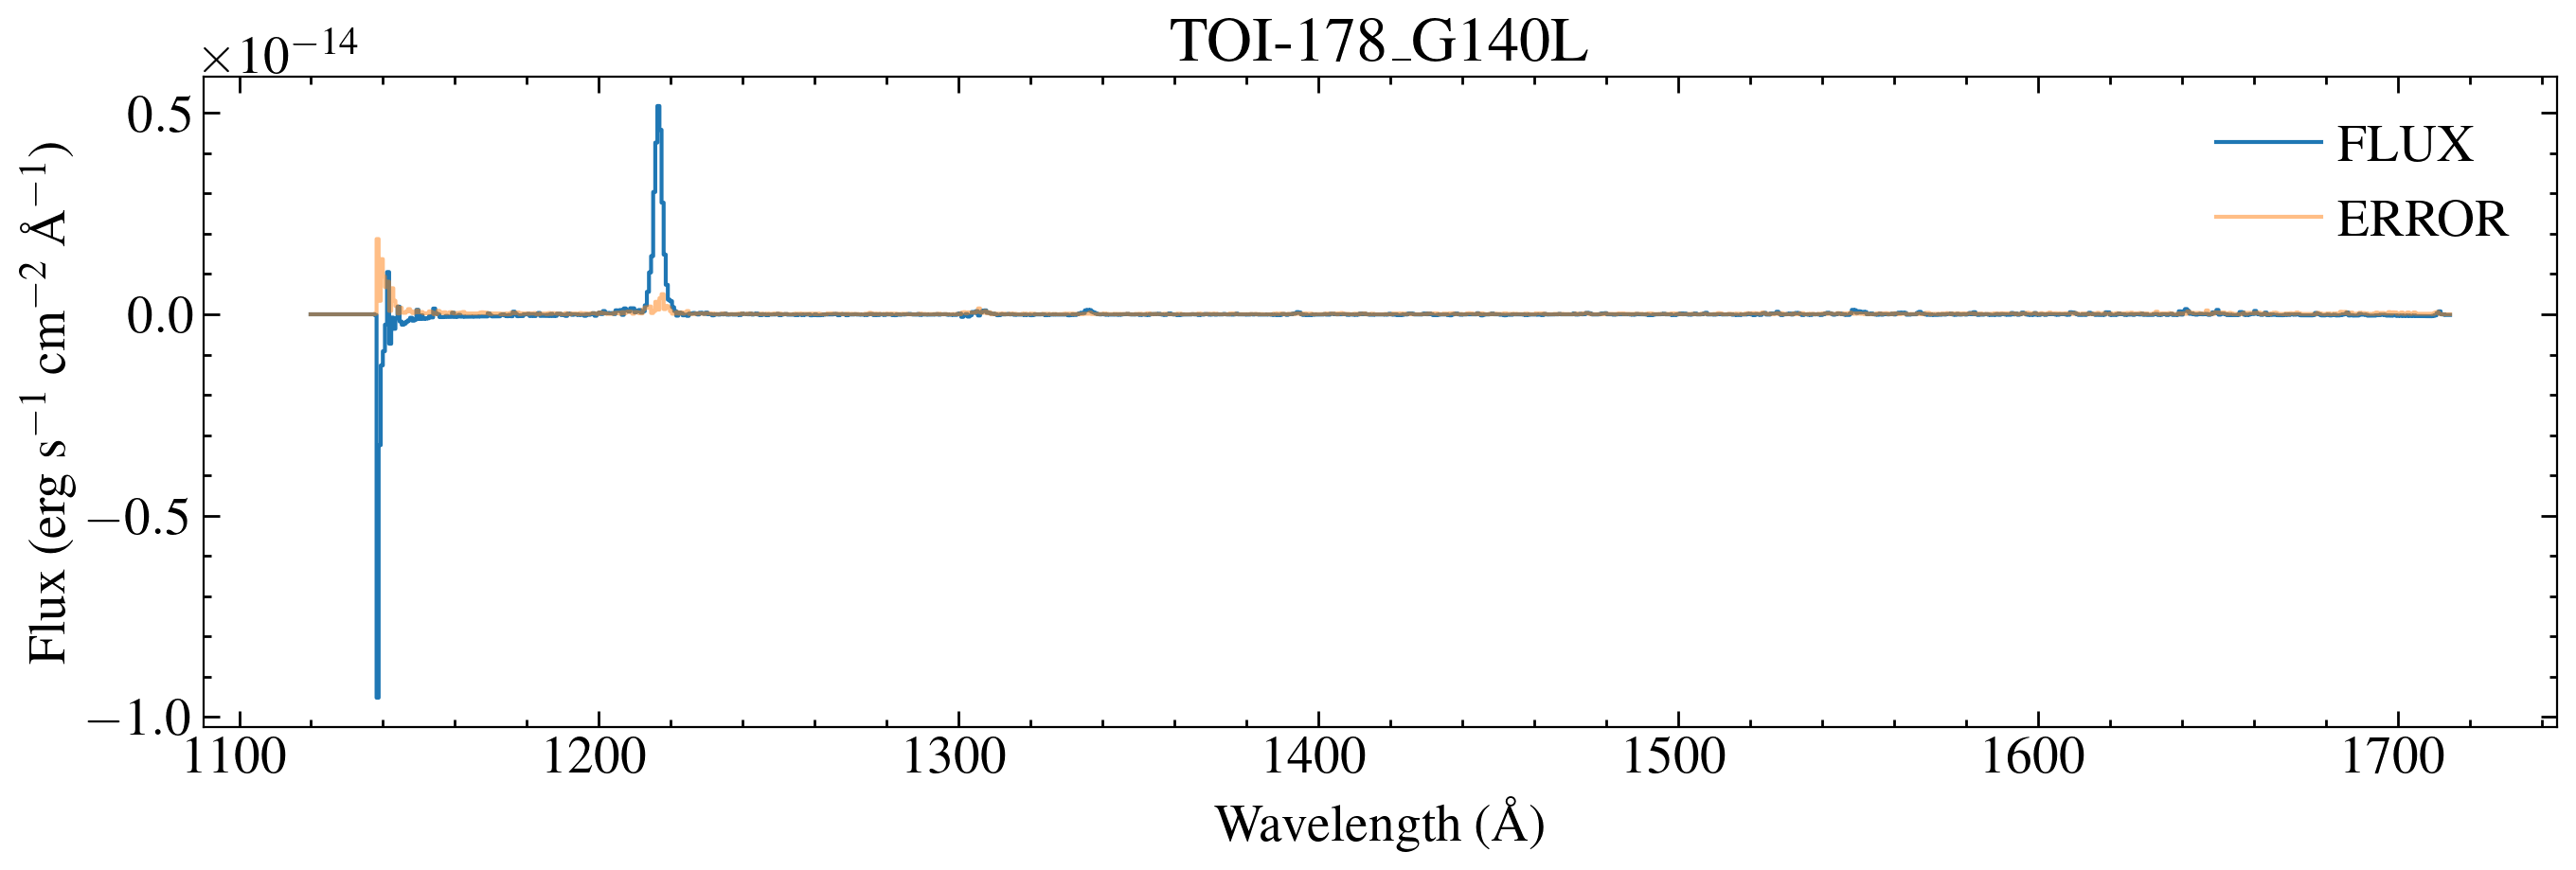

Spectrum saved as hlsp_muscles_hst_stis_toi-178_g140l_v1_component-spec.fits


/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/astropy/stats/funcs.py:745: RuntimeWarning: invalid value encountered in sqrt
  [n + 0.5 - np.sqrt(n + 0.25), n + 0.5 + np.sqrt(n + 0.25)]
/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.11/site-packages/numpy/lib/function_base.py:553: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


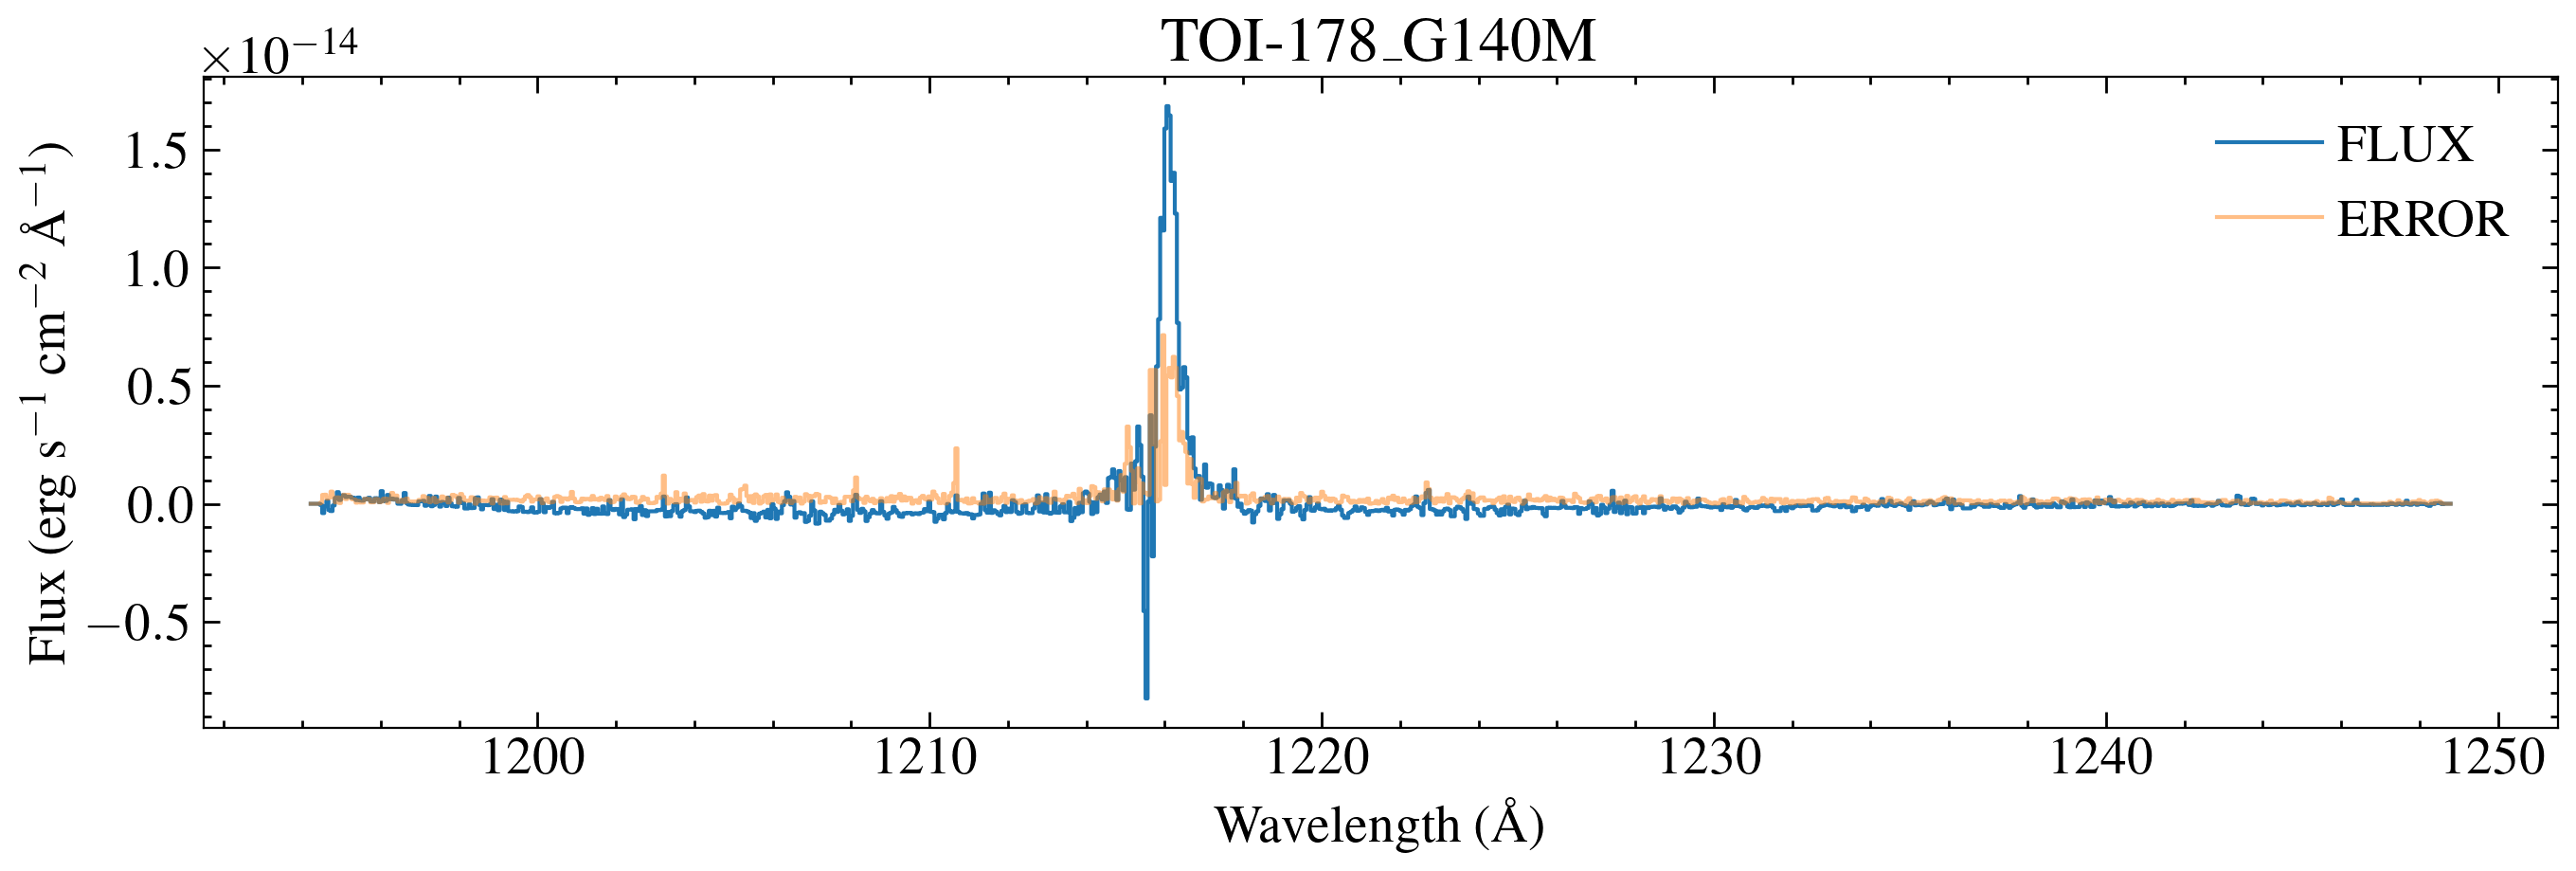

Spectrum saved as hlsp_muscles_hst_stis_toi-178_g140m_v1_component-spec.fits


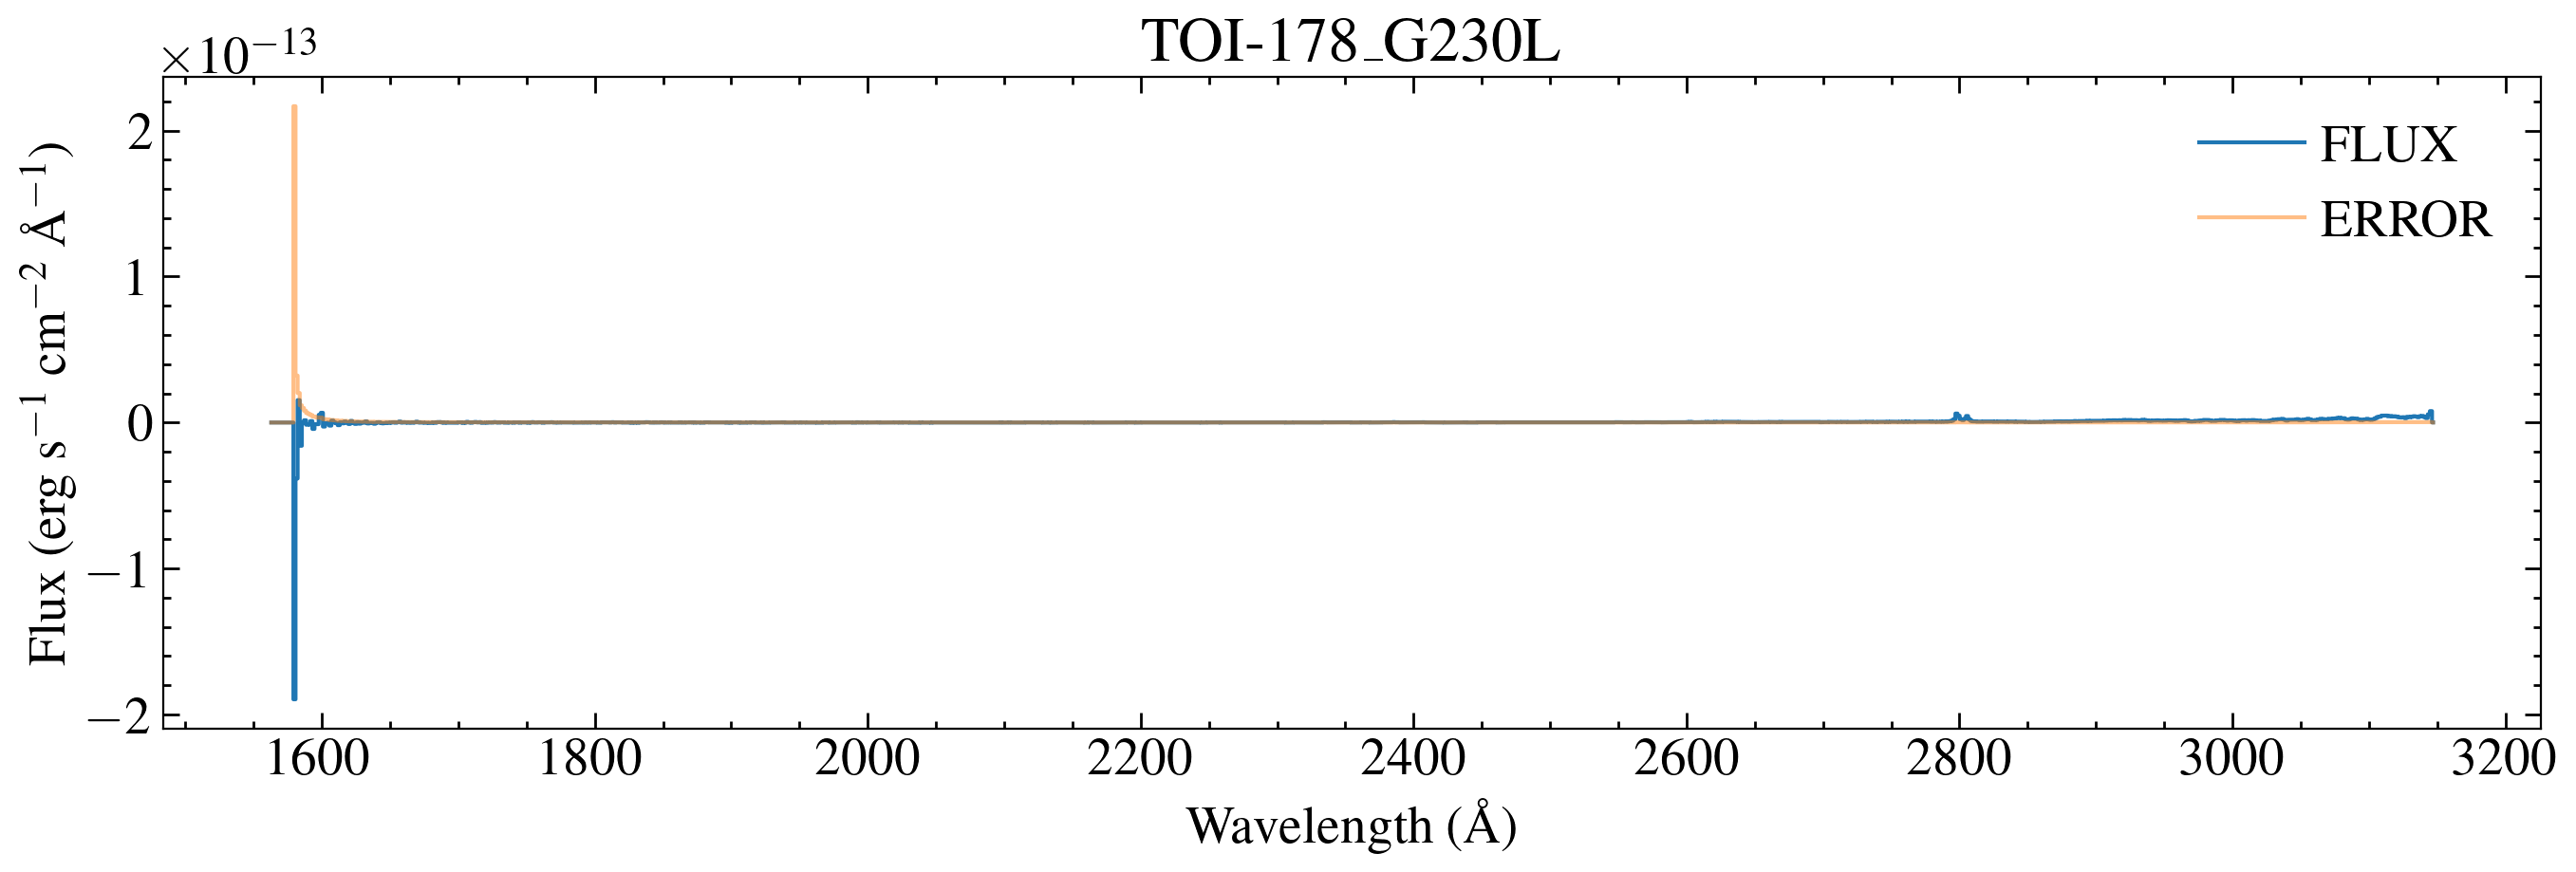

Spectrum saved as hlsp_muscles_hst_stis_toi-178_g230l_v1_component-spec.fits


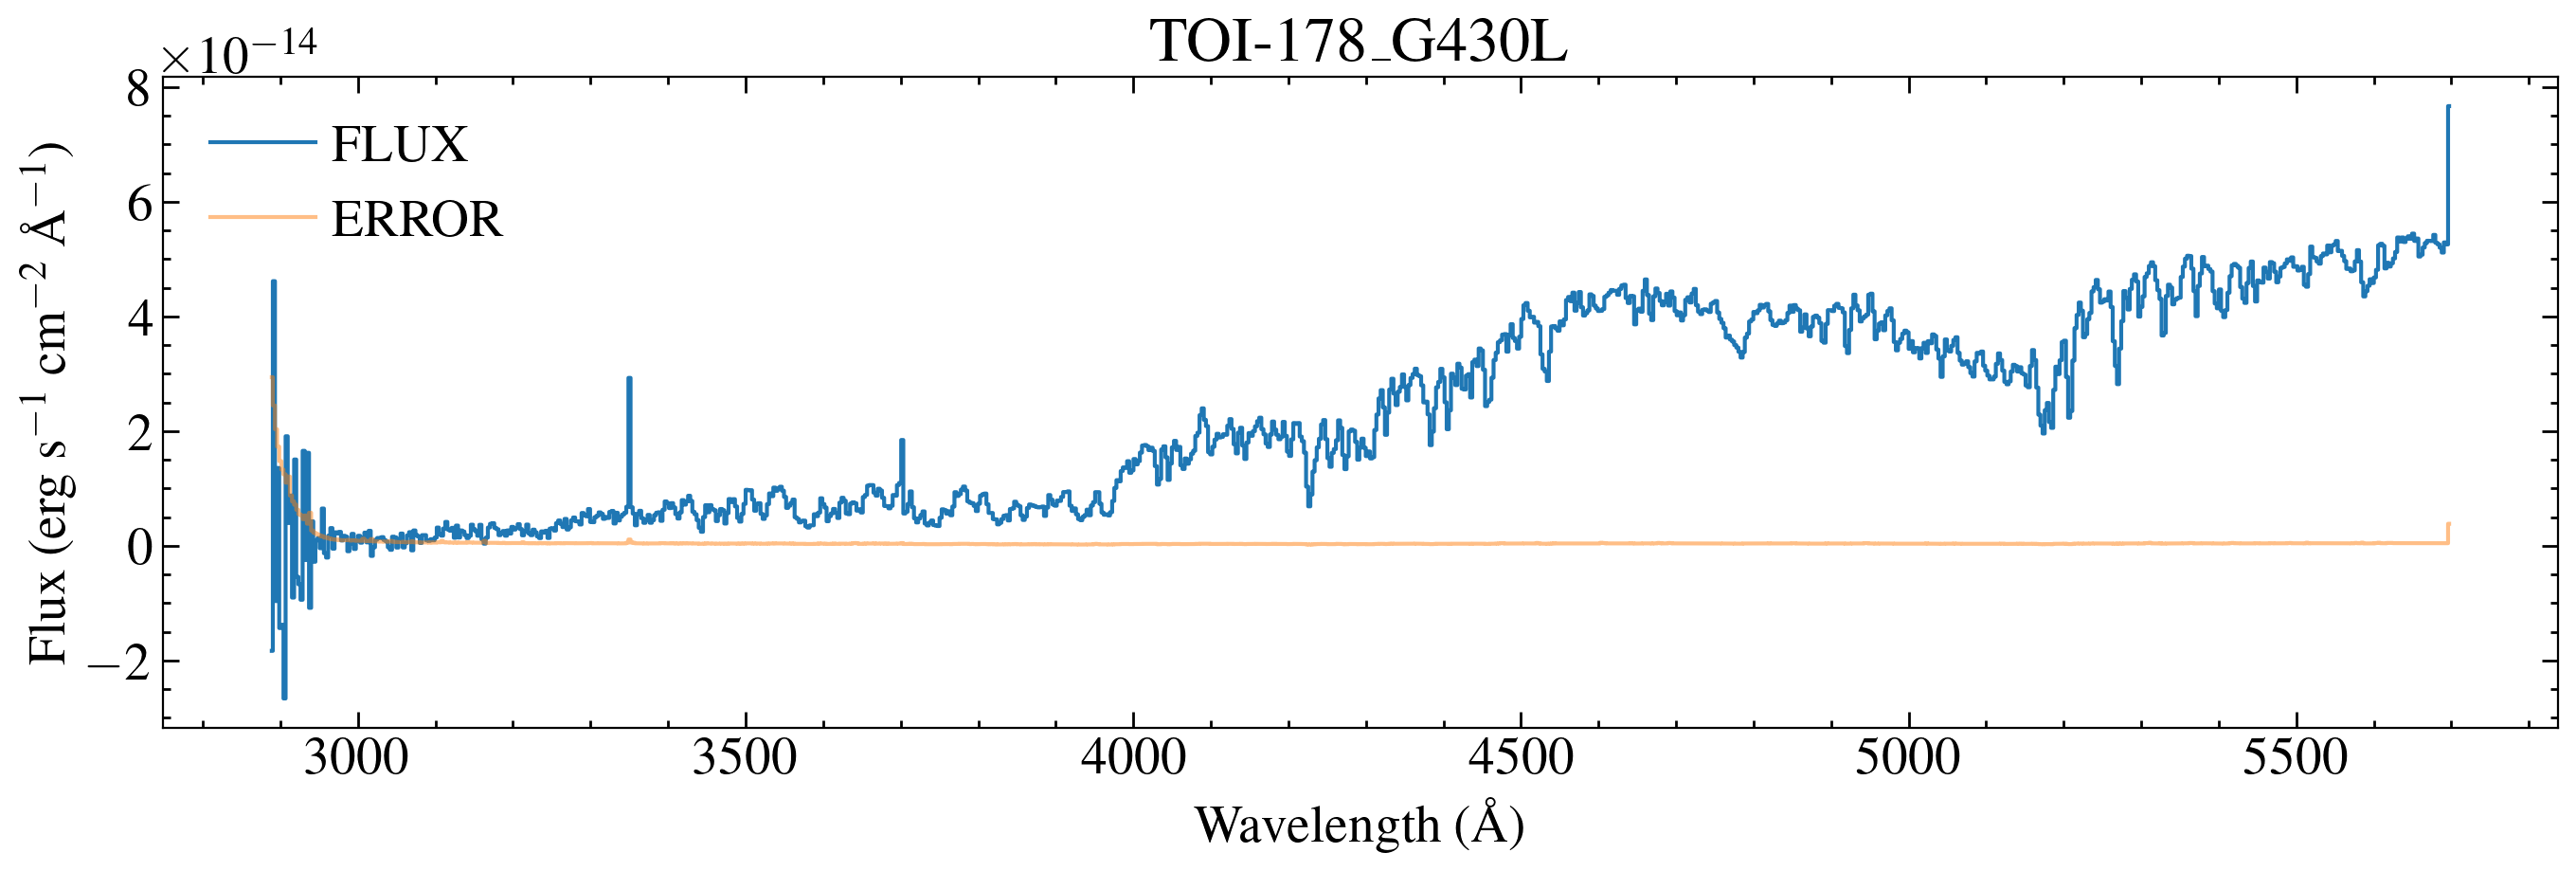

Spectrum saved as hlsp_muscles_hst_stis_toi-178_g430l_v1_component-spec.fits


In [75]:
import prepare_stis
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/use_spectra/'
savepath = 'draft_hlsp/toi-178/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'TOI-178')

<!-- Checking all the spectra I've done to send Bella... -->

In [17]:
# specs = glob.glob('../spectra_for_bella/*.fits')
# specs

In [18]:
# for spec in specs:
#     fig, ax= plt.subplots()
#     data = fits.getdata(spec, 1)
#     w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     mask = w > 1160
#     w, f, e = w[mask], f[mask], e[mask]
#     plt.step(w, f, where='mid', c='C0')
#     plt.step(w, e, where='mid', c='C1')
#     plt.show()

    
   

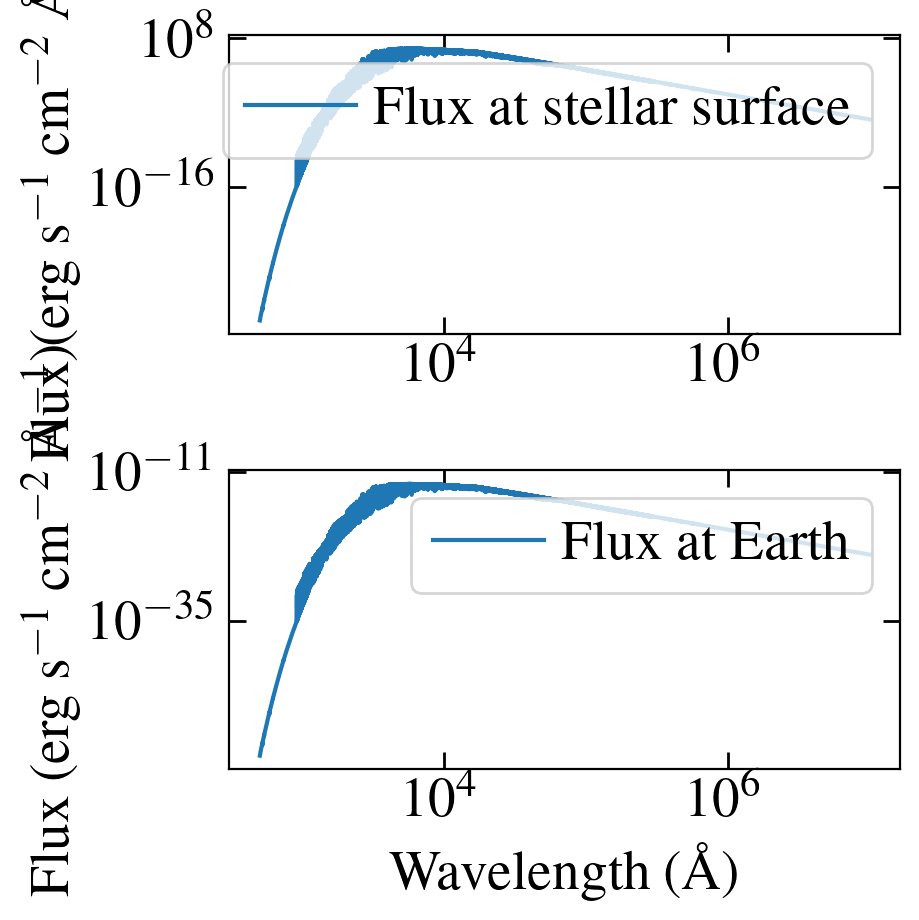

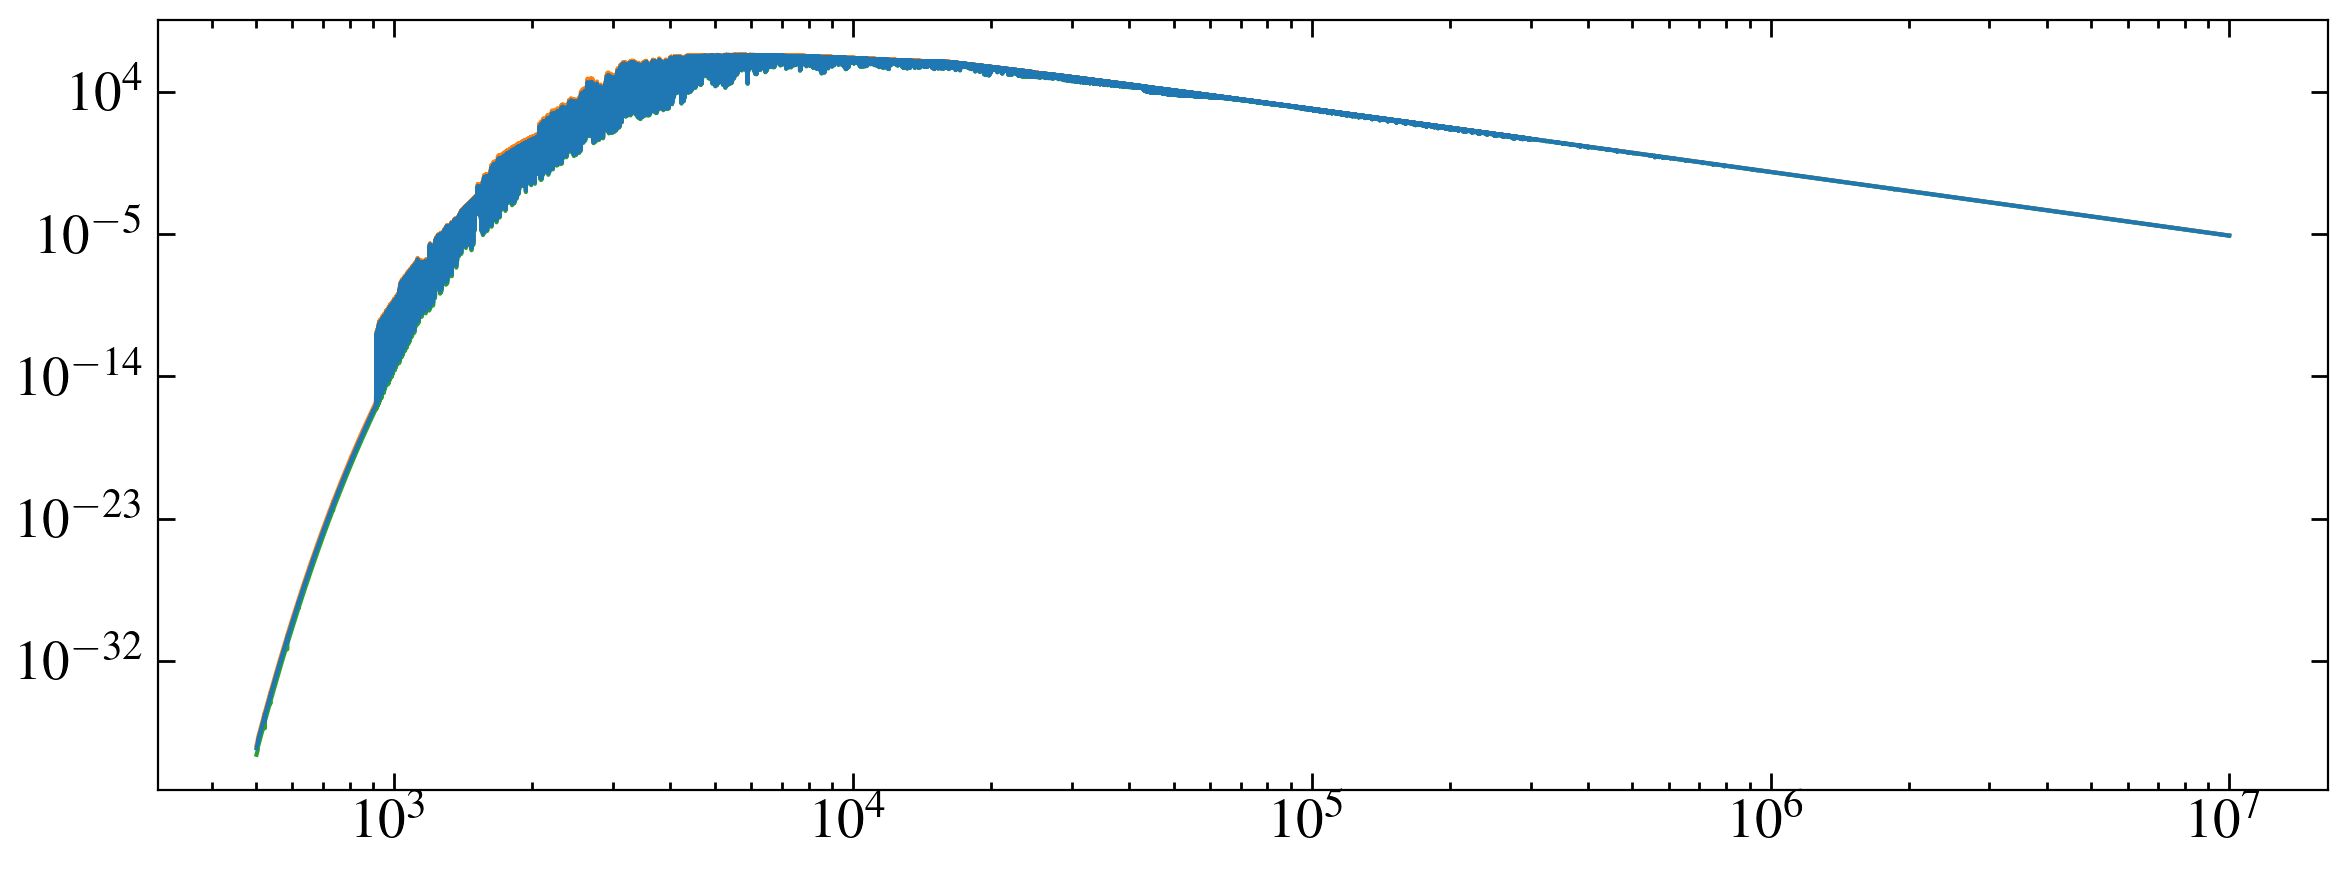

In [19]:
# import prepare_phoenix_svo as pp
# # importlib.reload(pp)

# G = const.G
# M = const.M_sun.to(u.kg)
# R = const.R_sun.to(u.m)
# mass = 0.65
# teff = 4316
# teff_e = 70

# radius = 0.651
# distance = 62.81

# save_path = 'models/'
# star = 'toi-178'
# # g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
# g = 4.62
# repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

# star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# # pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
# pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
# pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
# normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [20]:
import prepare_model
hdr = fits.getheader('draft_hlsp/toi-178/hlsp_muscles_hst_stis_toi-178_g140l_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)



Spectrum saved as hlsp_muscles_model_phx_toi-178_na_v1_component-spec.fits


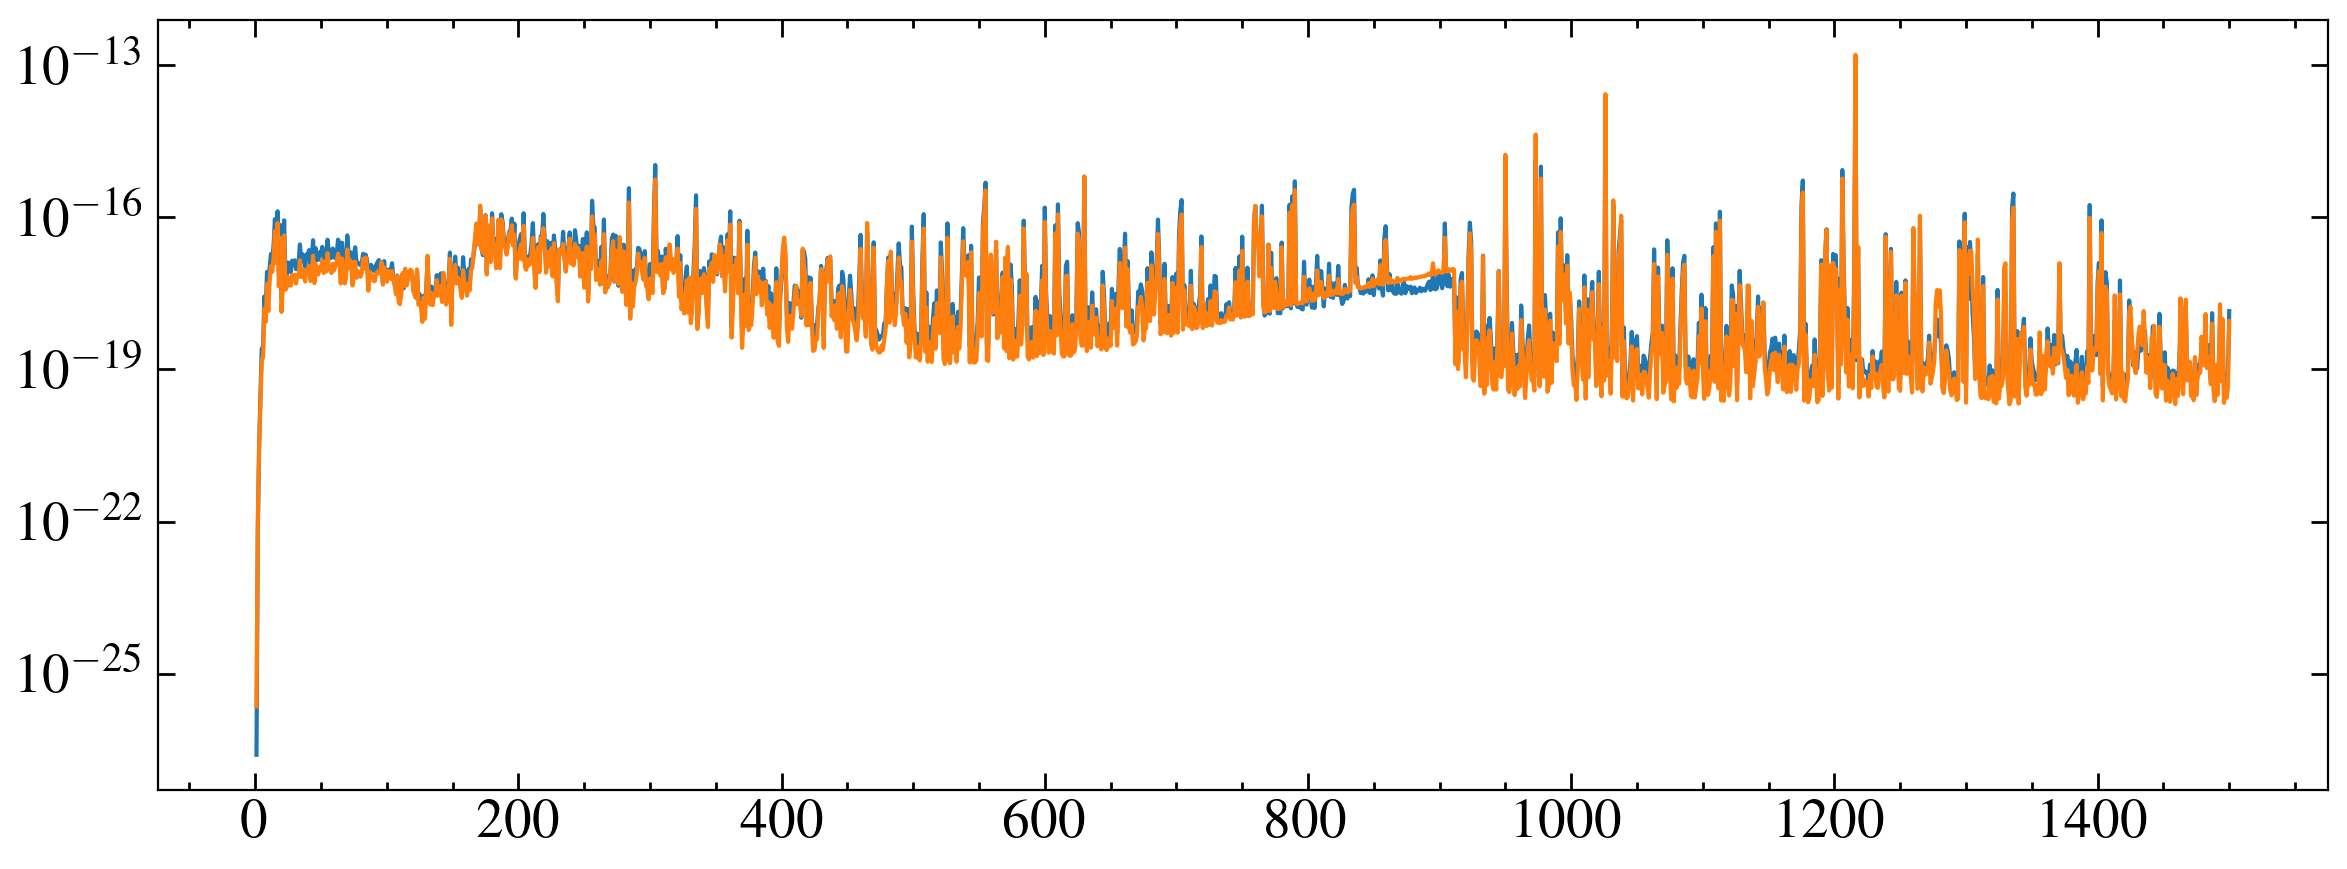

In [21]:
# dem
dempath = '/media/david/2tb_ext_hd/hddata/meats/dems/toi-178/spectrum_toi-178_p17.fits'
dem = fits.getdata(dempath, 1)

dw, df= dem['Wavelength'], dem['Flux_density']
eu, el = dem['Upper_Error_84'], dem['Lower_Error_16']


mean_e = np.mean([eu, el], axis=0)
# plt.plot(dw, mean_e)
# plt.yscale('log')

log_mean_e = (eu - el) / (np.log(eu)- np.log(el))

plt.plot(dw, df)
plt.plot(dw, log_mean_e)
# plt.plot(dw, mean_e)

plt.yscale('log')

demtab = Table([dw, df, log_mean_e], names=['WAVELENGTH', 'FLUX', 'ERROR'])
demtab.write('models/toi-178_dem.ecsv', overwrite=True)



In [22]:
prepare_model.make_model_spectrum('models/toi-178_dem.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='dem')

Spectrum saved as hlsp_muscles_model_dem_toi-178_na_v1_component-spec.fits


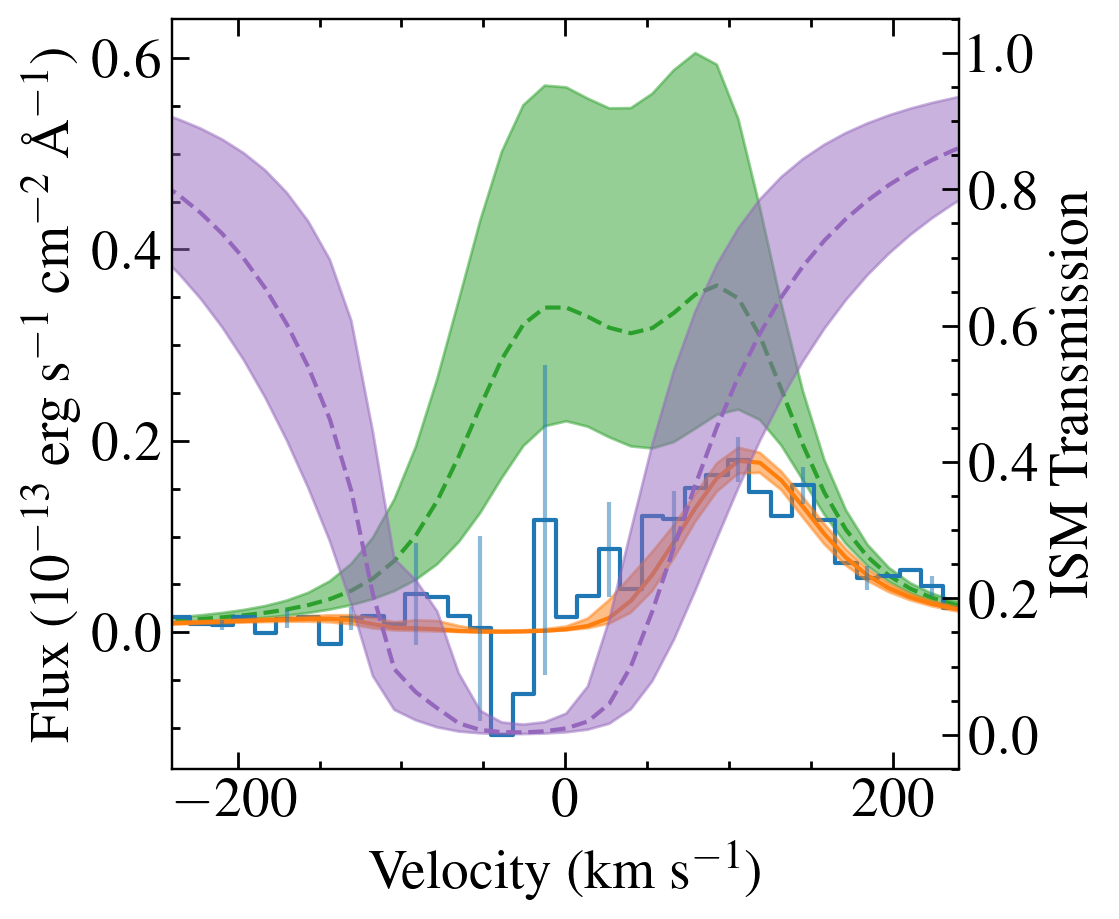

In [23]:
lyapath = '/media/david/2tb_ext_hd/hddata/meats/lya/toi-178/TOI178_LyA_MCMC_results.csv'
data = Table.read(lyapath)
# data.dtype.names
lya = 1215.67
ism_scale = 2.3e-13 #scaling ism to plot
fscale = 1e13 #scaling flux to axis
ism_scale *= fscale

fig, ax= plt.subplots(figsize=(6,5))
v = (data['wave_lya']*u.AA).to(u.km/u.s,  equivalencies=u.doppler_optical(lya*u.AA))
ax.step(v, data['flux_lya']*fscale, c='C0', label = 'Observed Spectrum', zorder=0, where='mid')
ax.errorbar(v, data['flux_lya']*fscale, yerr=data['error_lya']*fscale, alpha=0.5, errorevery=3, ls='none', c='C0')
ax.plot(v, data['lya_model_median']*fscale, c='C1', label='Model fit', zorder=1)
ax.fill_between(v.value, data['lya_model_high_1sig']*fscale,data['lya_model_low_1sig']*fscale, color='C1', alpha=0.5)

ax.plot(v, data['lya_intrinsic_median']*fscale, c='C2', ls='--', label=r'Intrinsic Ly$\alpha$ profile', zorder=-1)
ax.fill_between(v.value, data['lya_intrinsic_high_1sig']*fscale,data['lya_intrinsic_low_1sig']*fscale, color='C2', alpha=0.5, zorder=-10)

# name = os.path.split(spec)[1][:-34]
# ax.set_title(name, size=20)

# xlim = min([abs(min(v.value)), max(v.value)])-10
xlim = 240
ax.set_xlim(-xlim, xlim)
ax2=ax.twinx()
ax2.plot(v, data['lya_ism_median'], c='C4', ls='--', alpha=1, label='ISM profile', zorder=-9)
ax2.fill_between(v.value, data['lya_ism_high_1sig'],data['lya_ism_low_1sig'], color='C4', alpha=0.5, zorder=-10)
ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel('ISM Transmission')


ax.set_xlabel('Velocity (km s$^{-1}$)', size=20)
ax.set_ylabel('Flux (10$^{-13}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)

fig.tight_layout()

# fig.savefig('plots/toi-776_lya.pdf')

In [24]:
lw, lf, le = data['wave_lya'], data['lya_intrinsic_median'], np.mean([data['lya_intrinsic_high_1sig']-data['lya_intrinsic_median'], data['lya_intrinsic_median']-data['lya_intrinsic_low_1sig']], axis=0)
lyatab = Table([lw, lf, le], names=['WAVELENGTH', 'FLUX', 'ERROR'])
lyatab.write('models/toi-178_lya.ecsv', overwrite=True)

prepare_model.make_model_spectrum('models/toi-178_lya.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')


Spectrum saved as hlsp_muscles_model_lya_toi-178_na_v1_component-spec.fits


X-ray - Chandra spectrum, could be complicated.

0.0068912500000006816


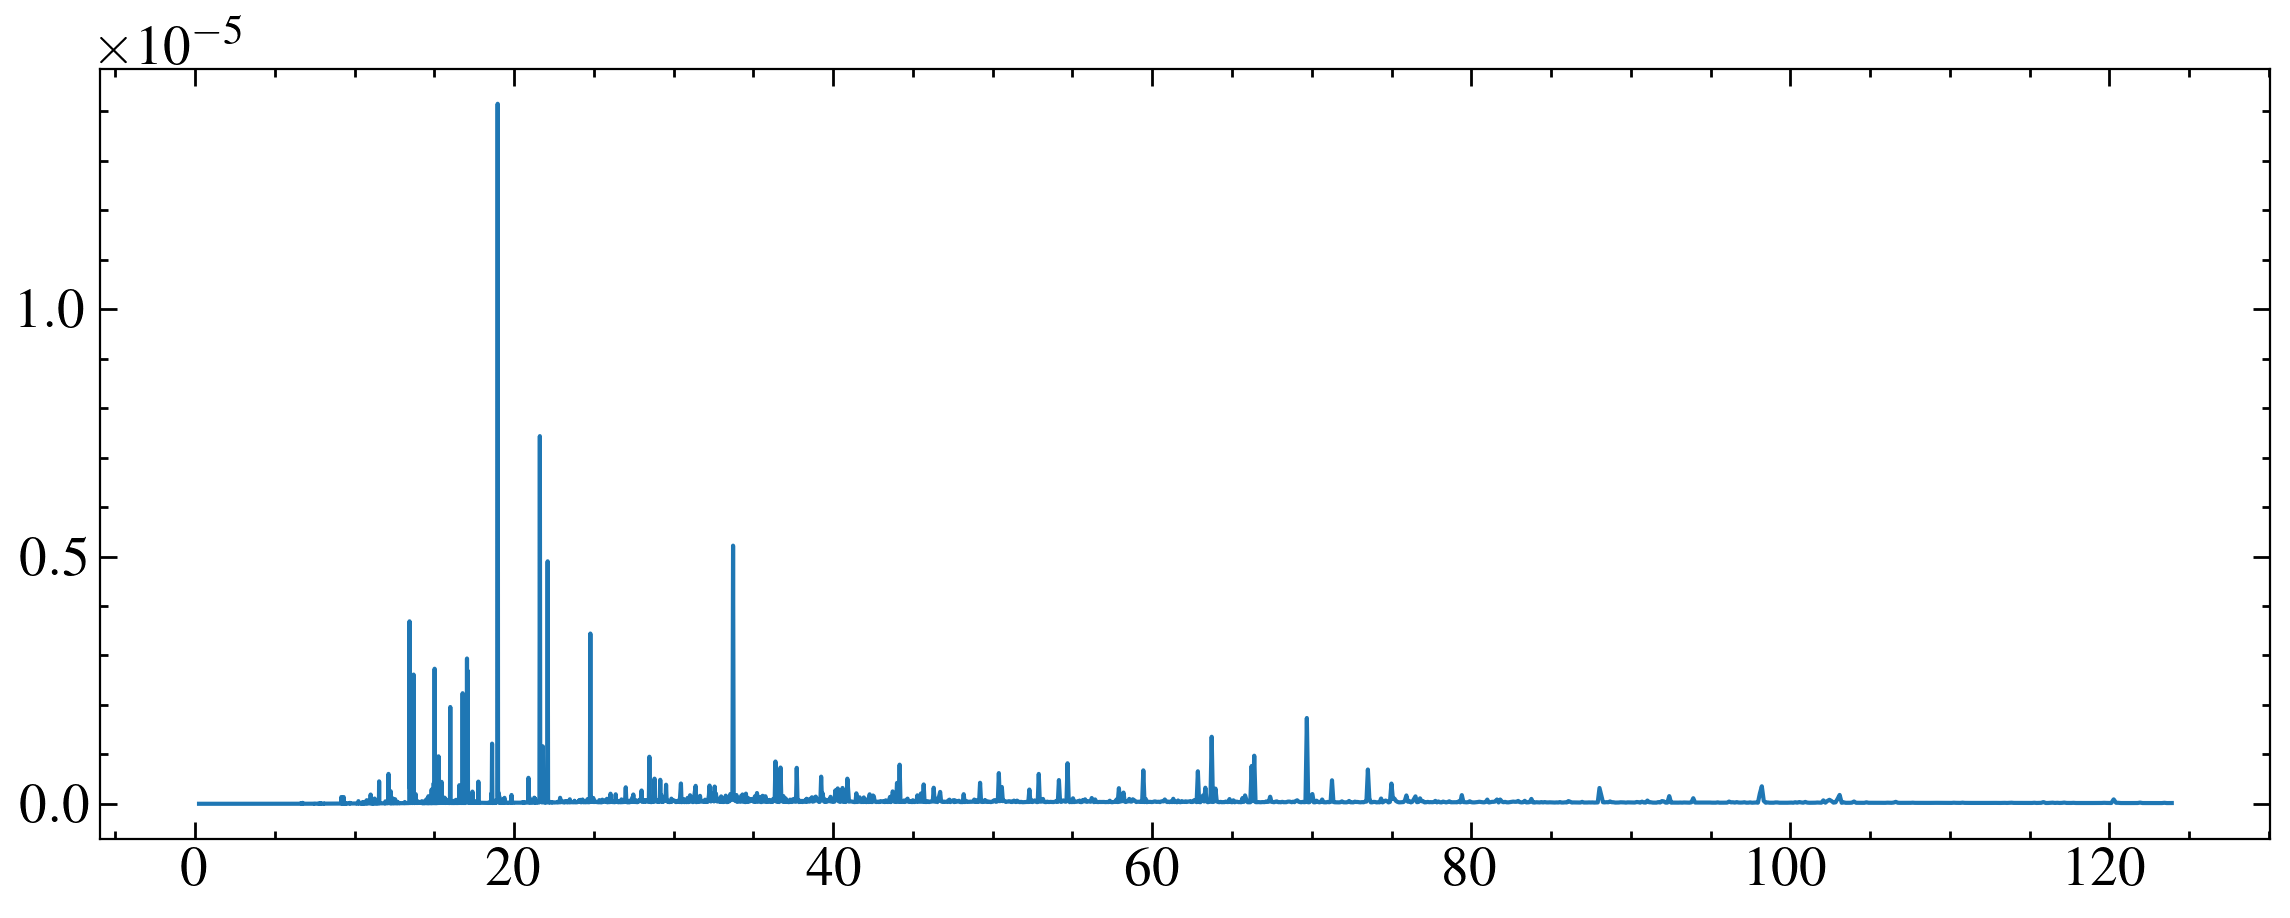

In [58]:
xspec = np.loadtxt('/media/david/2tb_ext_hd/hddata/meats/chandra/toi-178/TOI178_model_upperlimit.dat', skiprows =3)

fig, ax = plt.subplots()
# ax.plot(xspec[:,0], xspec[:,1])
ax.plot(xspec[:,0], xspec[:,2])
#w, bins, counts?
print(np.median(np.diff(xspec[:,0][::-1])))
#don't think its bins. make my own?

wx = xspec[:,0][::-1]*u.AA
fx  = (xspec[:,2][::-1] * (u.photon/u.s/u.cm**2/u.AA)).to(u.erg/u.s/u.cm**2/u.AA, equivalencies=u.spectral_density(wx))
wx, fx = wx.value, fx.value

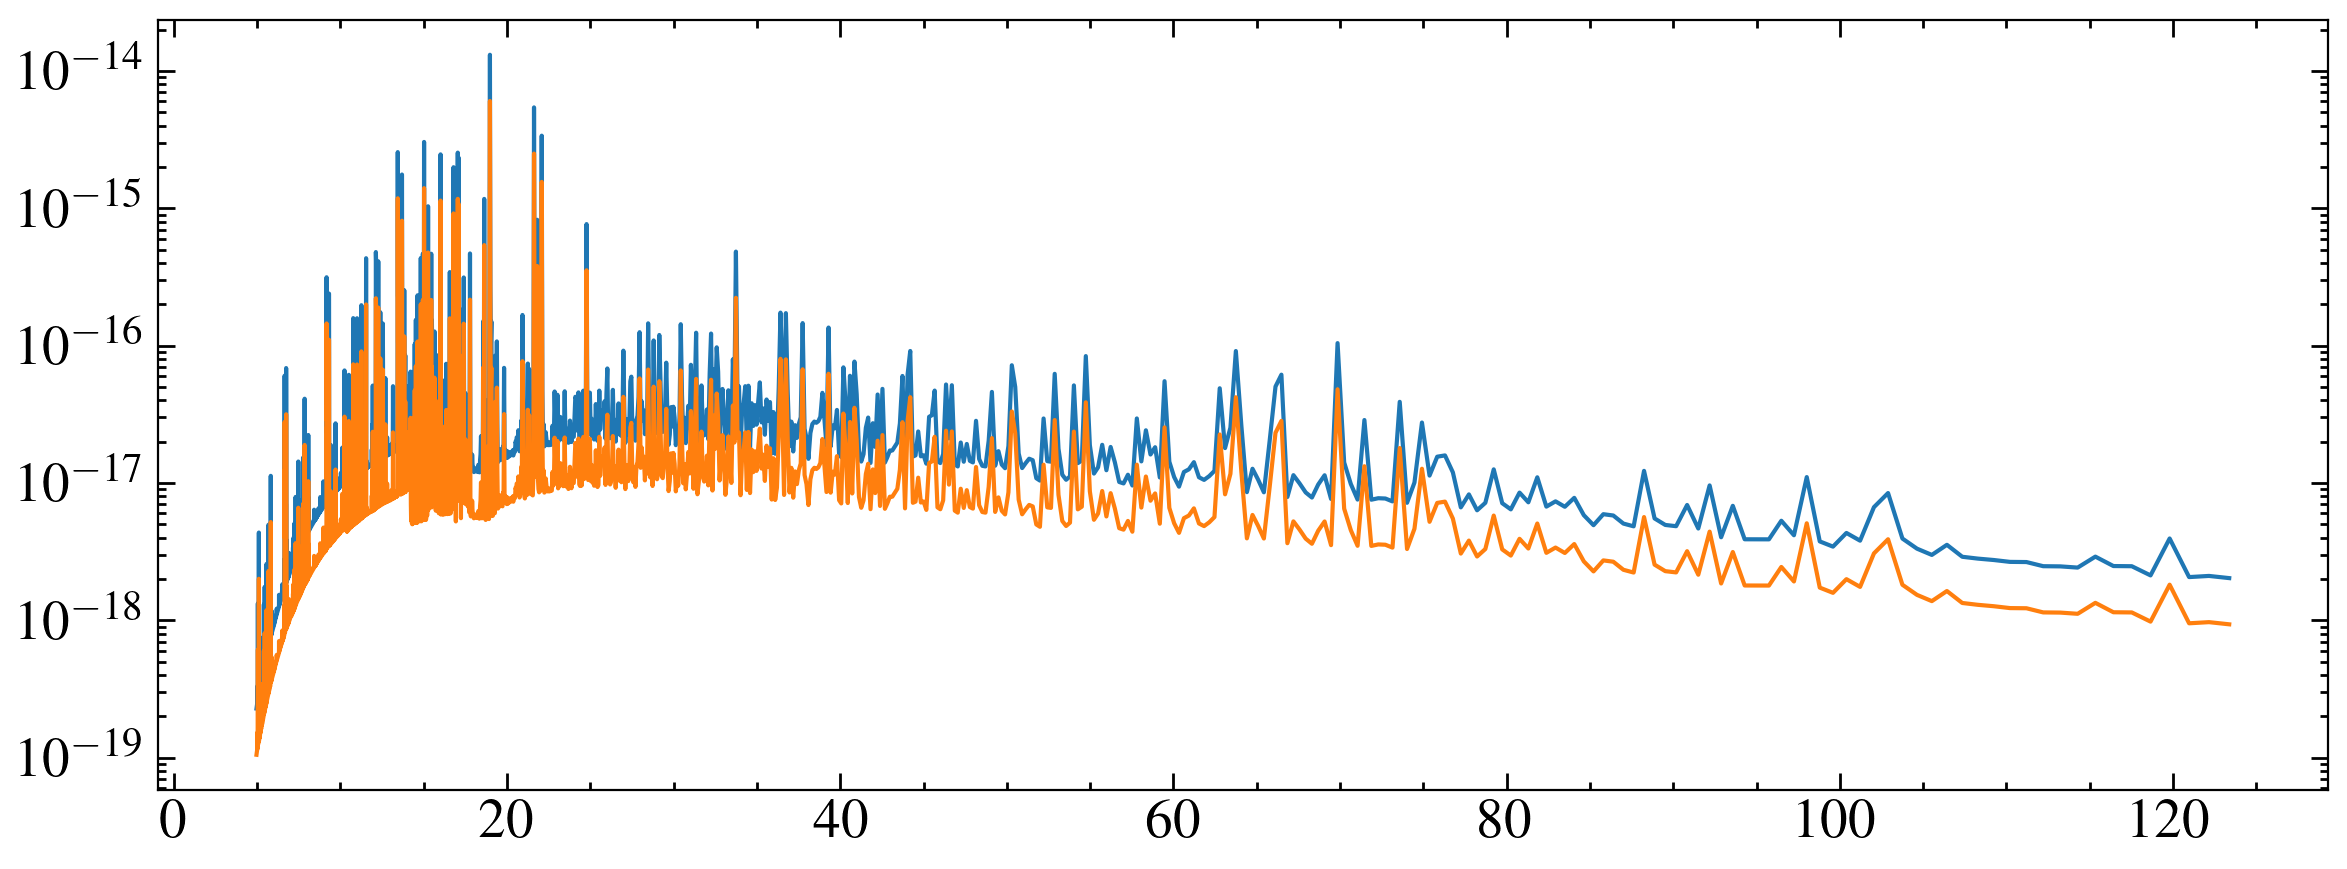

In [66]:
xray = Table.read('models/TOI-178_apec_errs.ecsv')
plt.plot(xray['WAVELENGTH'], xray['FLUX'])
plt.plot(xray['WAVELENGTH'], xray['ERROR'])
# plt.plot(wx[wx >10], fx[wx >10])
# plt.plot(xray['WAVELENGTH'], xray['FLUX']*0.55)

plt.yscale('log')

Ok so it's the Fx value from Alex's notes * 55 % , with 50% errors per Girish

In [62]:
print(4.2*0.55)
print(4.2*0.55*0.5)

2.3100000000000005
1.1550000000000002


In [67]:
prepare_model.make_model_spectrum('models/TOI-178_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')

Spectrum saved as hlsp_muscles_model_apec_toi-178_na_v1_component-spec.fits


Not a great PHX match

In [68]:
hlsp_stis = glob.glob('draft_hlsp/toi-178/*stis*fits')
hlsp_stis

['draft_hlsp/toi-178/hlsp_muscles_hst_stis_toi-178_g140m_v1_component-spec.fits',
 'draft_hlsp/toi-178/hlsp_muscles_hst_stis_toi-178_g140l_v1_component-spec.fits',
 'draft_hlsp/toi-178/hlsp_muscles_hst_stis_toi-178_g230l_v1_component-spec.fits',
 'draft_hlsp/toi-178/hlsp_muscles_hst_stis_toi-178_g430l_v1_component-spec.fits']

In [70]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.65
teff = 4316
teff_e = 70

radius = 0.651
distance = 62.6990

save_path = 'models/'
star = 'toi-178'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.62
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=False, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

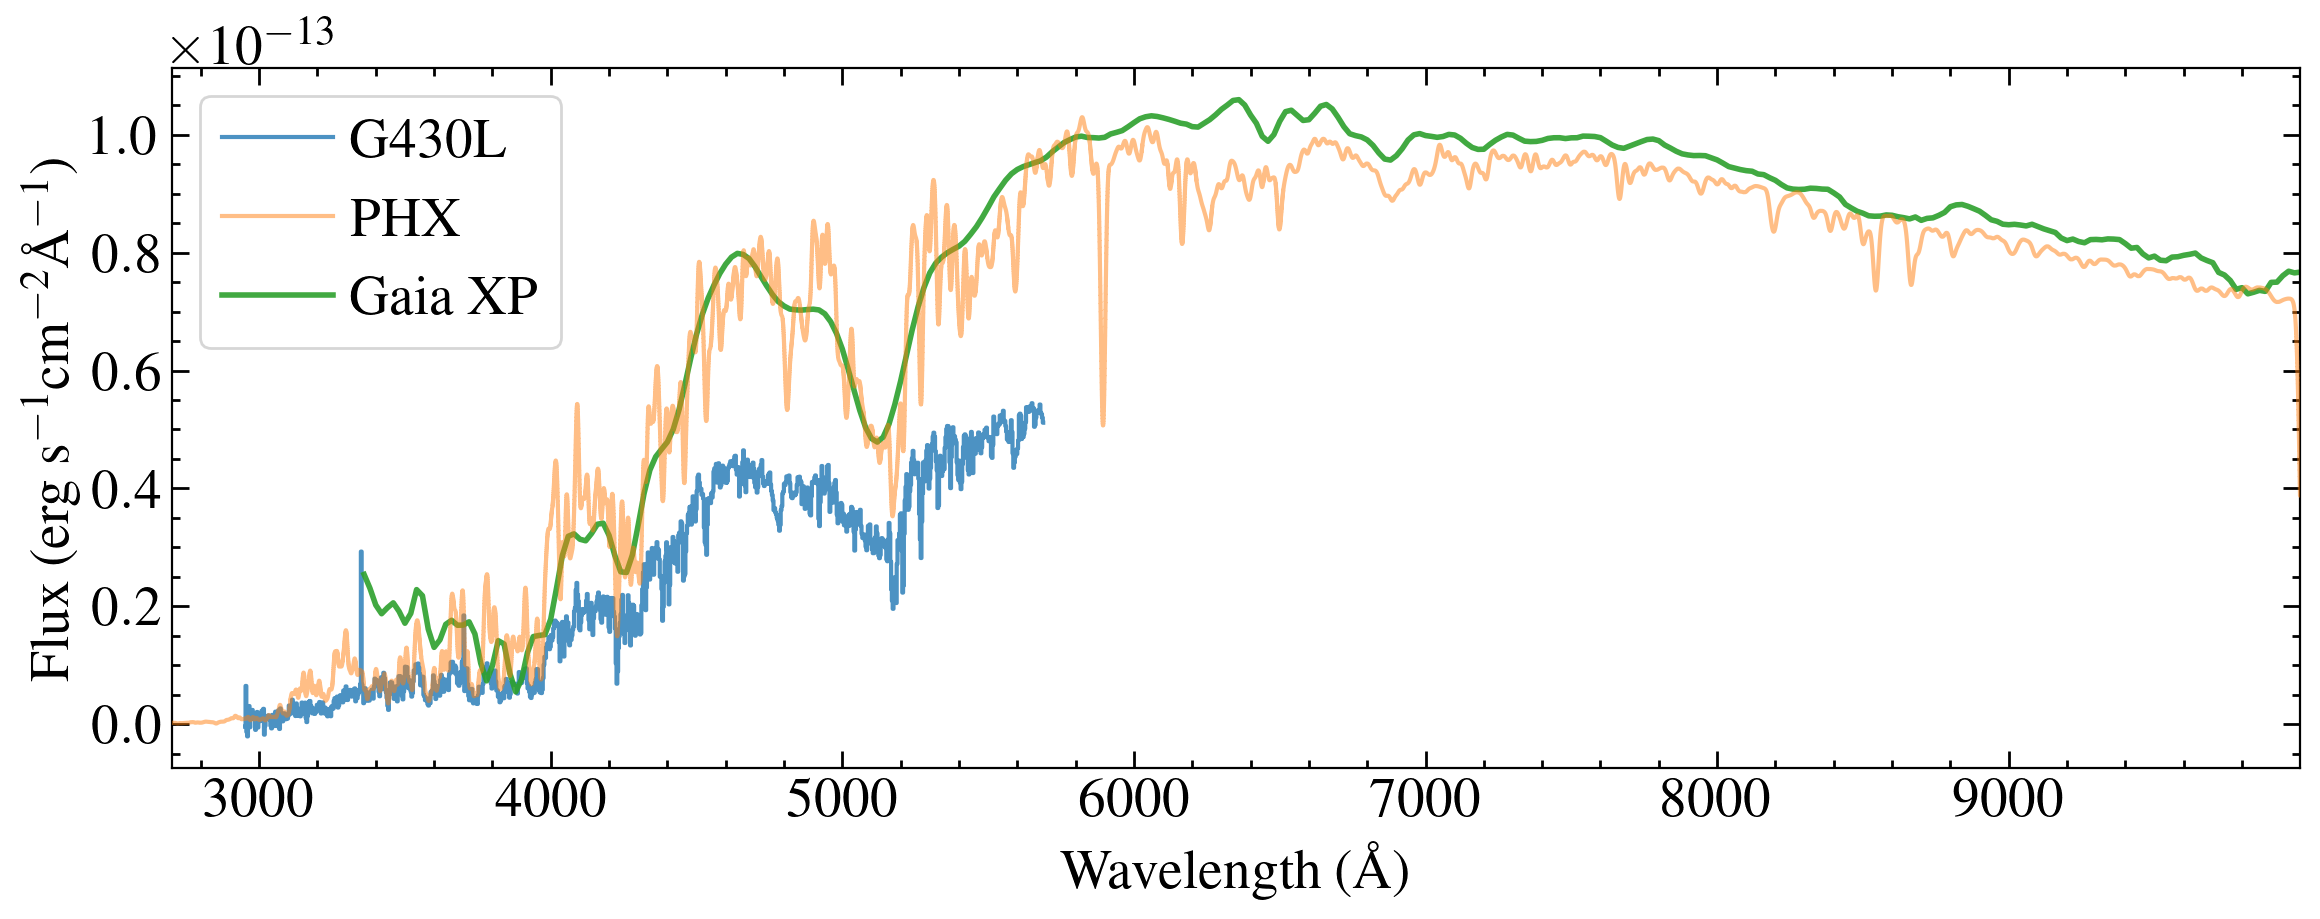

In [91]:


pmask = (pw > 2500) & (pw < 10000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 1000)


fig, ax = plt.subplots(figsize=(12,5))



# for spec in hlsp_stis:
spec = hlsp_stis[3]
data = fits.getdata(spec, 1)
w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']

mask = (w > 2950) & (w < 5690 )    
w, f, e = w[mask], f[mask], e[mask]

ow, of, oe = w, f,e 
ax.step(w, f, where='mid', label = 'G430L',  alpha=0.8)
  
ax.step(pwi, pfi, where='mid', zorder=10, alpha=0.5, label = 'PHX')


ax.set_ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')

gaia = Table.read('misc_data/toi-178_gaia/spectra_sampled_2318295979126499200.vot')
mask = gaia['type'] == 'XP'
gw, gf = gaia['wavelength'][mask]*10, gaia['flux'][mask]*(u.W/u.m**2/u.nm).to(u.erg/u.s/u.cm**2/u.AA)
# mask = (gw > 4000) #& (gw < 1000)
# gw, gf = gw[mask], gf[mask]
ax.plot(gw, gf, label ='Gaia XP', alpha=0.9, lw=2)


ax.legend(frameon=True)

ax.set_xlim(2701, 9999)

fig.tight_layout()




Catastrophic. Other solutions are similar, is the problem the spectrum? Oh no, spectrum

In [77]:
# #PHX
prepare_model.make_model_spectrum('models/toi-178_phoenix_interpolated.ecsv', 1, sed_data, savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')

Spectrum saved as hlsp_muscles_model_phx_toi-178_na_v1_component-spec.fits


Something up with the flux calibration. HST archive says aperture was shut, but that's clearly a spectrum - wrong exposure time?  

Definitely something in the crj files  

Exptime makes no sense - that's just the gap twixt two exposures? Did only one exposure happen? No seems like two equal brightness exposures.  

Scaling is about 1.8

In [78]:
hdul = fits.open('/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/optical/oeoo21050_sx1.fits')

In [79]:
hdr = hdul[0].header

In [82]:
print(((hdr['TEXPEND'] - hdr['TEXPSTRT'])*u.d).to(u.s))
print(hdr['TEXPTIME'])

164.0001602936536 s
120.0


In [83]:
hdul.close()

In [84]:
hdul = fits.open('/media/david/2tb_ext_hd/hddata/meats/hst/toi-178/optical/oeoo21050_flt.fits')


In [88]:
for i in [1, 4]:
    hdr = hdul[i].header
    print(((hdr['EXPEND'] - hdr['EXPSTART'])*u.d).to(u.s))
    print(hdr['EXPTIME'])

60.00048047862947 s
60.0
59.999616094864905 s
60.0


Scale to the model - its the same as k2-141, keep it constistent

5.48003919803975e-20
1.7161213416451744


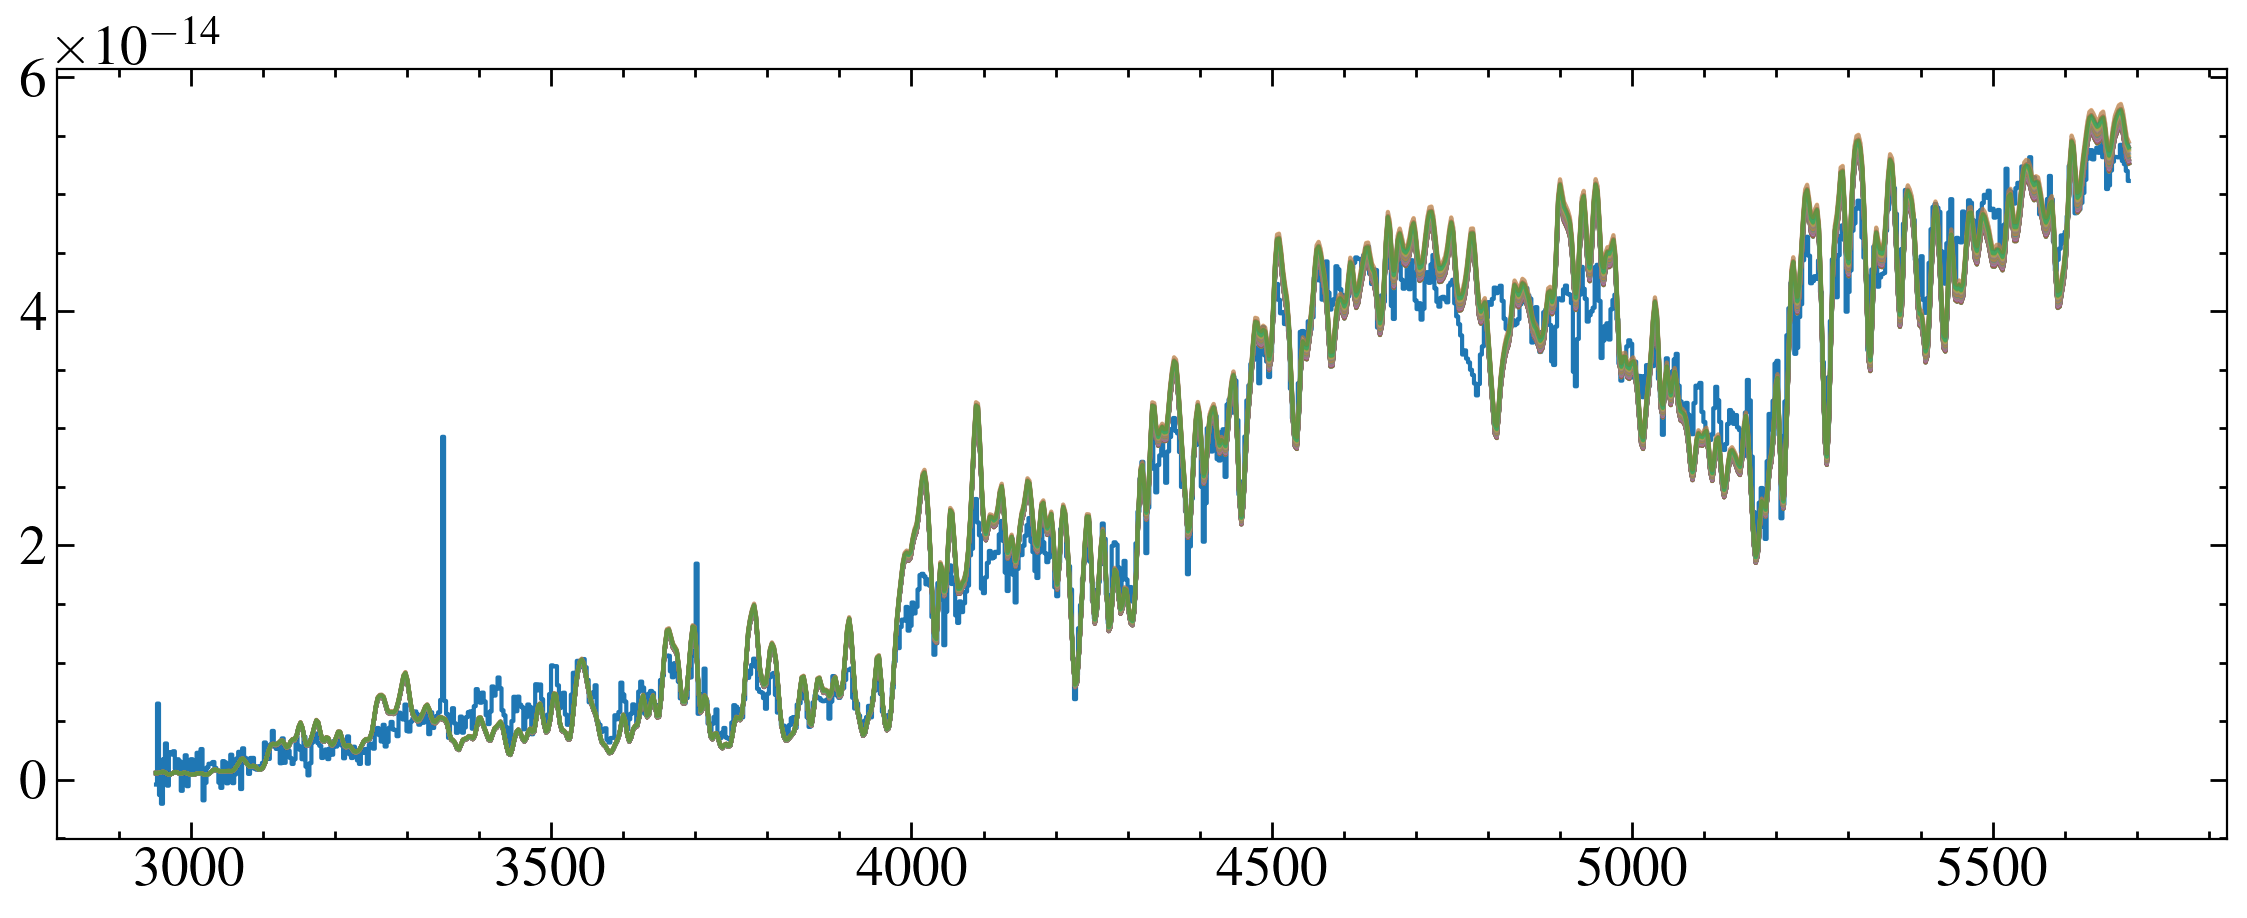

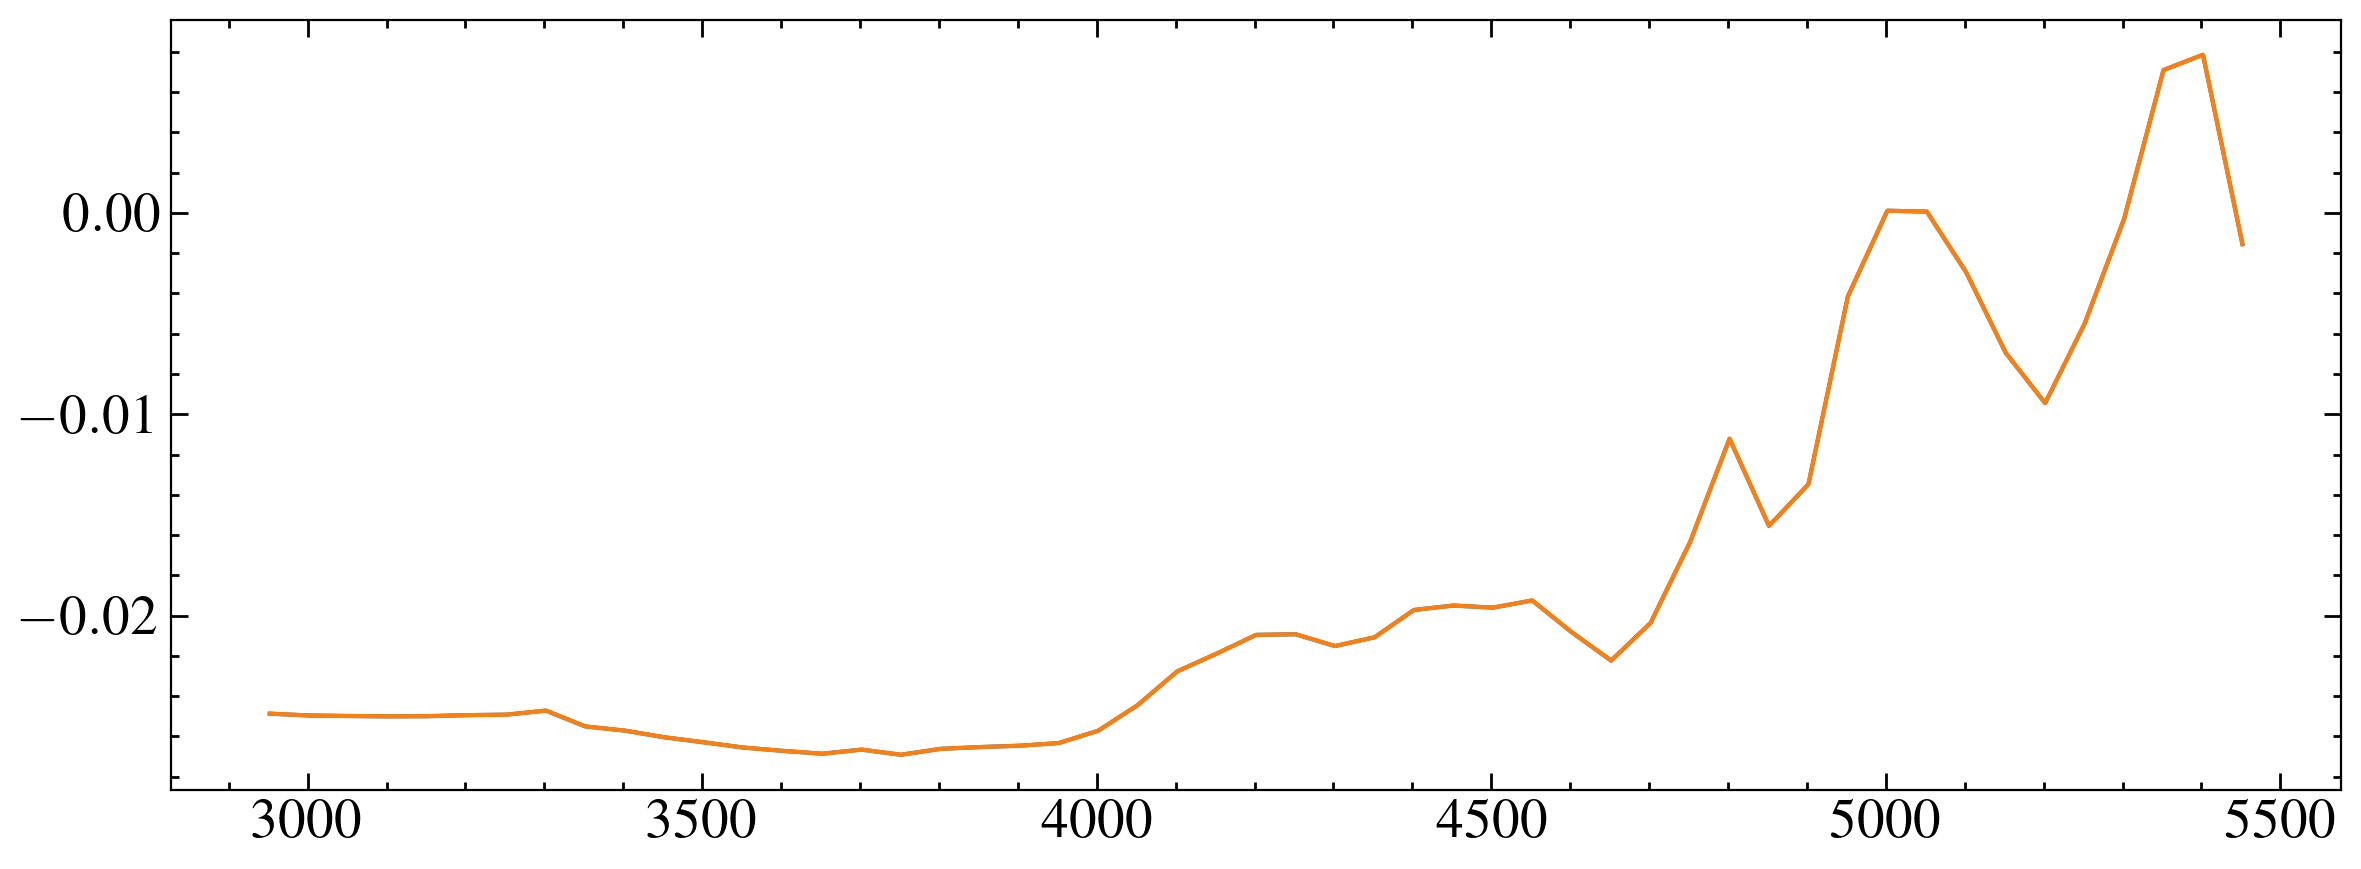

In [96]:
from astropy.convolution import convolve, Gaussian1DKernel
from scipy.optimize import leastsq


def guass_smooth(wavelength, flux, A = 'none', R='none', Lambda = 'none'):
    """
    Takes a spectrum and Guassian smooths it either to a angstroms per resel A or an R value. If the wavelength Lambda at which R is evaluated is not supplied it takes the central wavelength of the spectrum.   
    """
    respix = (wavelength[-1] - wavelength[0])/len(wavelength)
    if A == 'none':
        try: 
            R != 'none'
        except:
            print('Error: I need either an Angstroms per resolution element A or a resolution R = Lambda/A')
            return
        if Lambda == 'none':
            Lambda = (wavelength[-1] + wavelength[0])/2 #mid point of spectrum
            print(Lambda)
        A = Lambda / R
        # print(A)
    FWHM = A/respix 
    sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
    f_smooth = convolve(flux, Gaussian1DKernel(sigma))
    return f_smooth
    

def residuals(scale, f, mf):
    return f - mf/scale
    
R = 500
A = 2.37
cenwave = 4300

fig, ax = plt.subplots()


# ax.step(ow, of, where='mid')
mask = (pw > ow[0]-100) & (pw < ow[-1]+100)
pwi, pfi = pw[mask], pf[mask]*normfac 

# ax.plot(pwi, pfi, alpha = 0.5)

# pfA = guass_smooth(pwi, pfi, A=A)
# ax.plot(pwi, pfA, alpha=0.5)

pfR = guass_smooth(pwi, pfi, R=R, Lambda=cenwave)
# ax.plot(pwi, pfR, alpha=0.5)

pfR = np.interp(ow, pwi, pfR)

# ax.plot(ow, pfR)
# ax.plot(ow, pfR/of)

# ax.set_yscale('log')

# ax.set_ylim(2e20, 9e20)
# redo = ext.extinguish(ow*u.AA, Ebv = 0.045)


norm_mask = ow > 5000

norm = leastsq(residuals, normfac, args=(pfR[norm_mask], (of)[norm_mask]))[0][0]
print(normfac)
print(1/norm)

ax.step(ow, of, where='mid')
ax.plot(ow, pfR*norm)

flux_int = np.trapz(pfR*norm, ow)

starts = np.arange(ow[0], ow[-1]-200, 50)
norms = []
fluxes = []
for start in starts:
    norm_mask = ow > start
    normi =leastsq(residuals, normfac, args=(pfR[norm_mask], (of)[norm_mask]))[0][0]
    norms.append(normi)
    ax.plot(ow, pfR*normi, alpha=0.5)
    fluxi = np.trapz(pfR*normi, ow)
    fluxes.append(fluxi)
    
    


fig, ax = plt.subplots()

ax.plot(starts, (norms/norm)-1)
ax.plot(starts, (fluxes/flux_int)-1)
# ax.axhline(norm, ls='--', c='C2')
    

In [97]:
g430l = fits.open('draft_hlsp/toi-178/hlsp_muscles_hst_stis_toi-178_g430l_v1_component-spec.fits')
g430l[0].header['NORMFAC'] = 1/norm
g430l.writeto('draft_hlsp/toi-178/hlsp_muscles_hst_stis_toi-178_g430l_v1_component-spec.fits', overwrite=True)

In [98]:
starspec = fits.getdata('fixed_hlsp/toi-178/hlsp_muscles_multi_multi_toi-178_broadband_v25_adapt-const-res-sed.fits', 1)
starw, starf = starspec['WAVELENGTH'], starspec['FLUX']
sol = Table.read('Solar_1au_sed.ecsv')
sw, sf = sol['WAVELENGTH'], sol['FLUX']

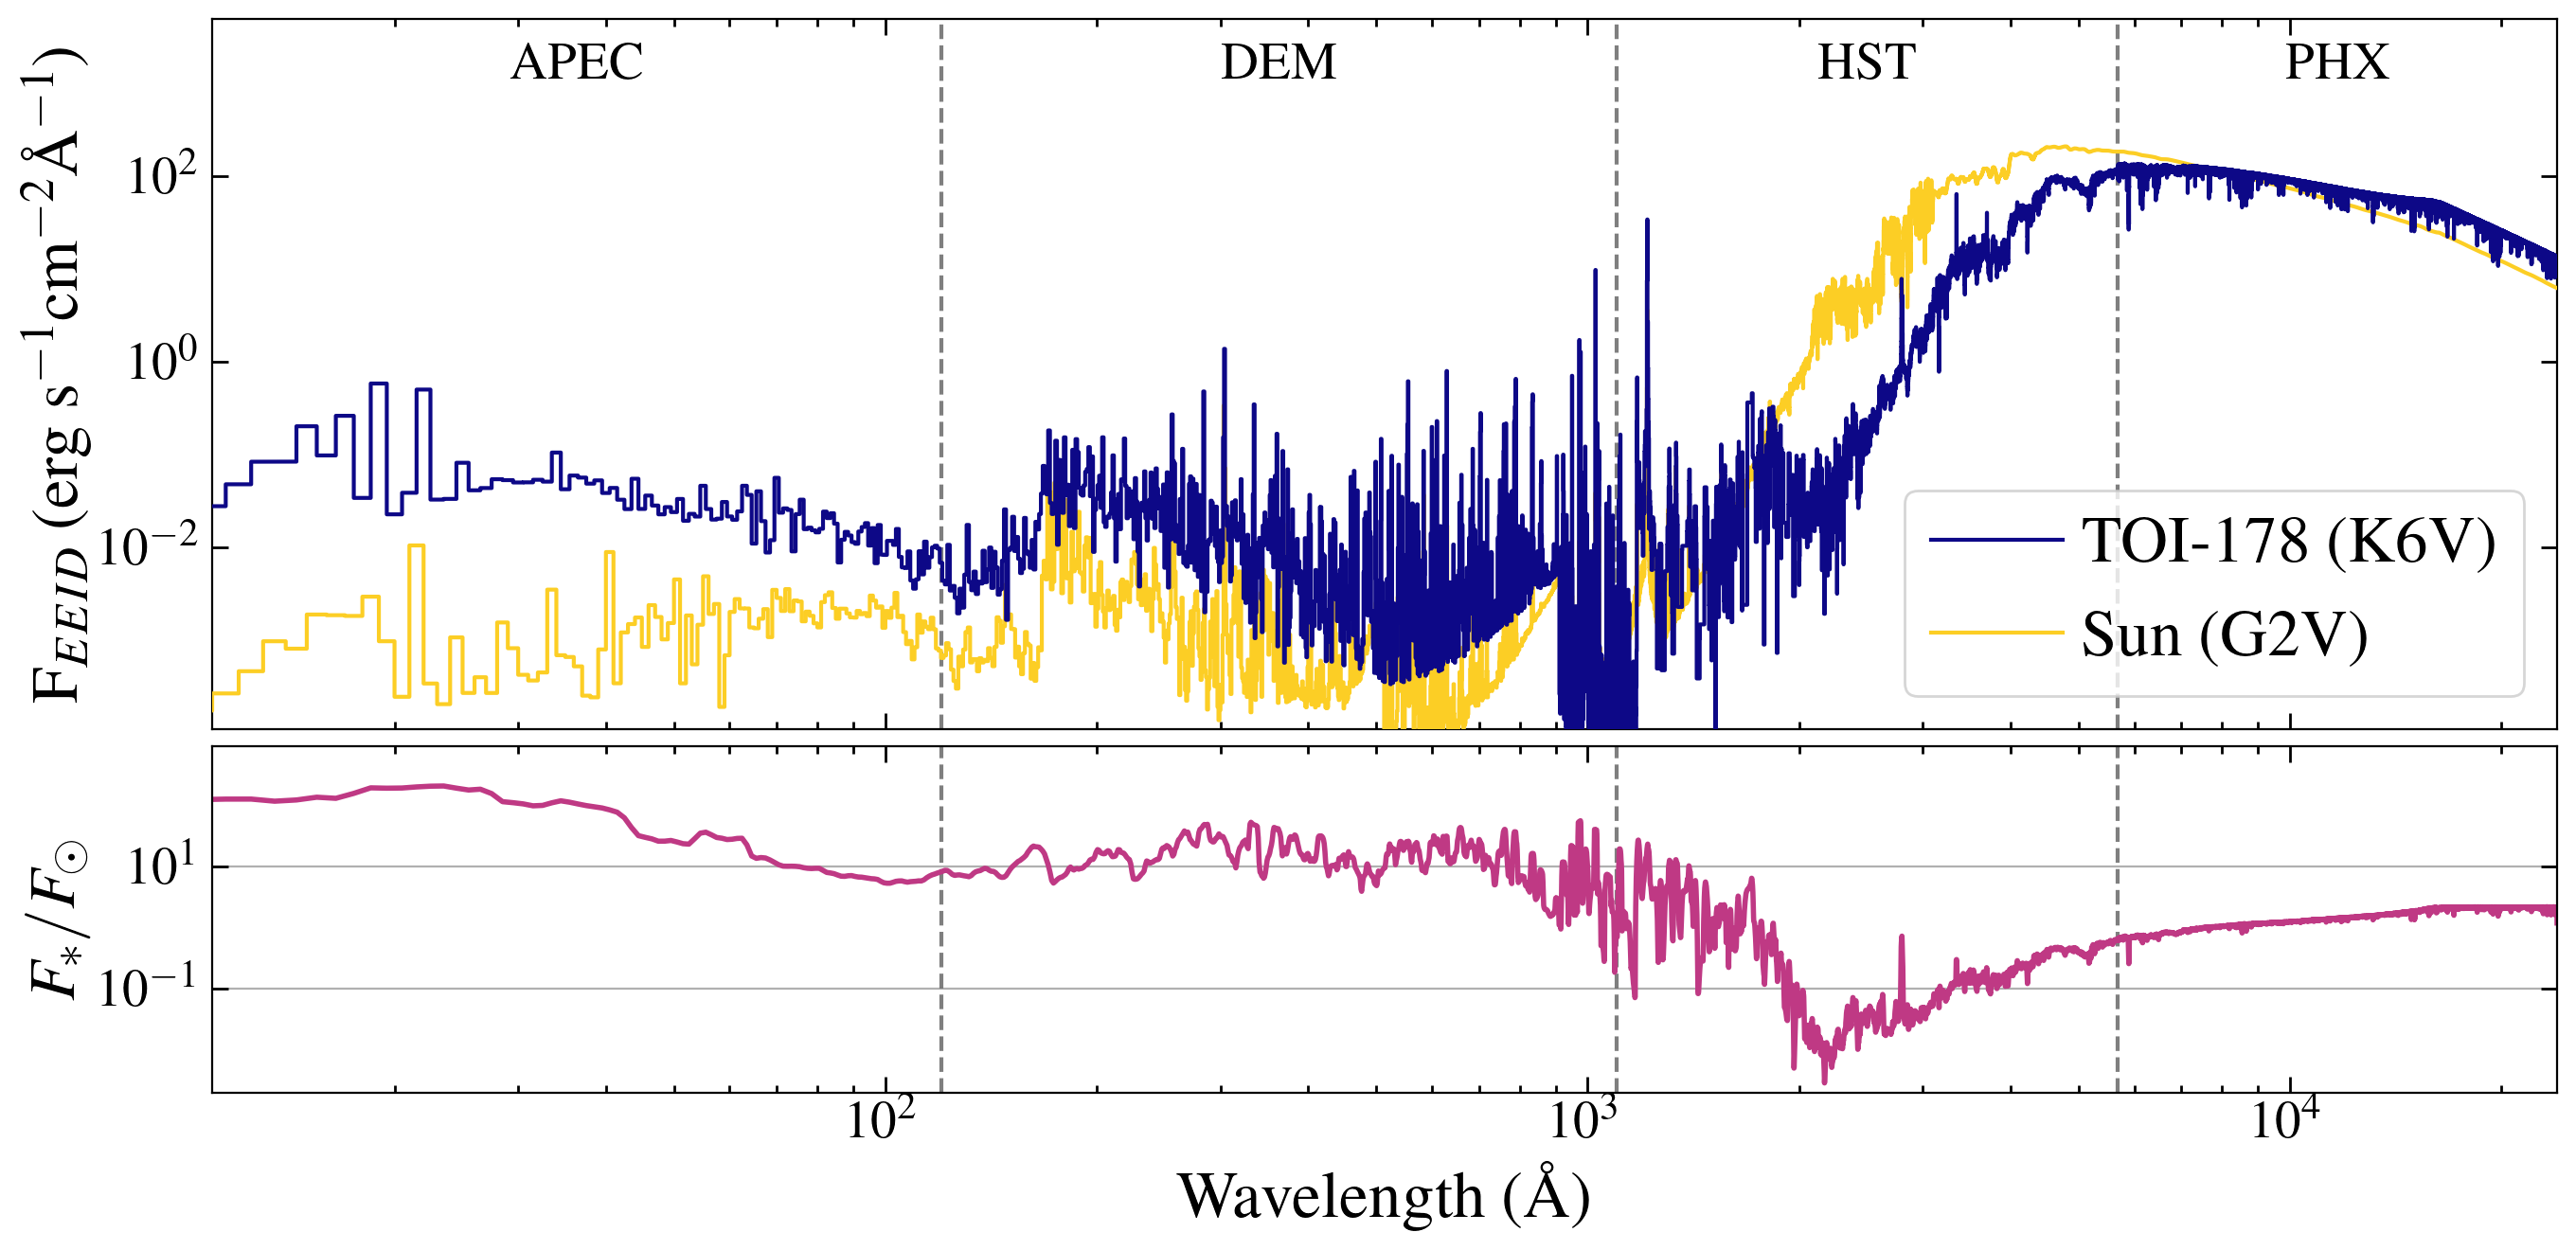

In [101]:

# cols = ['C0', 'C1', 'C2']
cols = [plt.cm.plasma(0),plt.cm.plasma(0.9), plt.cm.plasma(0.45)]

dstar = distance*u.pc
dsun = 1*u.au
lstar = 10**-0.879
# eeidau = 0.471*u.au
eeidau = (lstar**0.5)*1*u.au

solscale = lstar*(dsun.to(u.m)/dstar.to(u.m))**2
starscale = ((dstar.to(u.m))/(eeidau.to(u.m)))**2

fig, axes = plt.subplot_mosaic([[0,0,0],[0,0,0],[1,1,1]],figsize=(14, 7), sharex=True)


ax= axes[0]
ax.step(starw, starf*starscale, c=cols[0], label = 'TOI-178 (K6V)', zorder=12, where='mid')
ax.step(sw, sf, c=cols[1], label = 'Sun (G2V)', zorder=10, where='mid')
# ax.set_xlim(11, sw[-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.1e-4, 4.9e3)

bar_y = 1e3
label_y = bar_y*1.5
e_y = bar_y *0.3

xlims = (11, sw[-1])
ax.set_xlim(xlims[0], xlims[1])
divlines = (120, 1100, 5690)
[ax.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]

labels = ['APEC', 'DEM', 'HST', 'PHX']
labpos = np.sort(np.hstack((xlims, divlines)))

for i, label in enumerate(labels):
    label_x = (labpos[i]*labpos[i+1])**0.5
    ax.annotate(label, (label_x, label_y), ha='center', va='center')



ax.legend(fontsize=25, loc=4,frameon=True)
ax.set_ylabel('F$_{EEID}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)

ax1 = axes[1]
ax1.set_xlabel('Wavelength (\AA)', size=25)
[ax1.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]


mask = (starw> sw[0]) & (starw < sw[-1])
fnew = interp1d(starw[mask], starf[mask], fill_value='extrapolate')(sw)
fnew = fnew*starscale.value
ratio = fnew/sf
ratio = convolve(ratio,Box1DKernel(10))
ax1.plot(sw, ratio, c=cols[2], lw=2)
# ax1.set_ylim(0, 1000)

ax1.set_yscale('log')
ax1.set_ylim(2e-3, 9e2)
ax1.set_ylabel('$F_*/F_{\odot}$', size=25)
# ax1.axhline(1, ls='--', c='k', alpha=0.5)

ax1.grid(axis='y')
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


plt.savefig('plots/toi-178_v_sun.pdf')